### Table of contents
1. [Supp Figure 8A-B. Cox models for PFS in TKI arm of IMM151 and JAV101 (IFNG signatures)](#1)
2. [Supp Figure 8C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (IFNG signatures)](#2)
3. [Supp Figure 8E-F. Logistic regression models for CB vs NCB in TKI arm of IMM151 and JAV101 (IFNG signatures)](#3)
4. [Supp Figure 9A-D. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling)](#4)
5. [Supp Figure 9E. Scatter plot showing hazard ratios in Cox models for PFS for all myeloid signatures in IMM151 and JAV101 (IFNG signatures)](#5)

In [1]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(magrittr)
library(broom)
library(yarrr)

library(survival)
library(survminer)
library(tidyverse)
library(forestmodel)
library(scales)
library(pROC)
library(car)


set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

Loading required package: Rcpp

Loading required package: carData

corrplot 0.92 loaded

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject

Attaching sp

Loading required package: ggplot2


Attaching package: 'dplyr'


The following object is masked from 'package:car

In [2]:
ISG_sigs = readRDS("../../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

### Supp Figure 8A-B. Cox models for PFS in TKI arm of IMM151 and JAV101 (IFNG signatures) <a name="1"></a>

### Set panels for forest_model plots

In [3]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [4]:
clin_imm151_full = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

,Var1,Freq
,<fct>,<int>
8604,IFIT3,2



 CB NCB 
255 123 

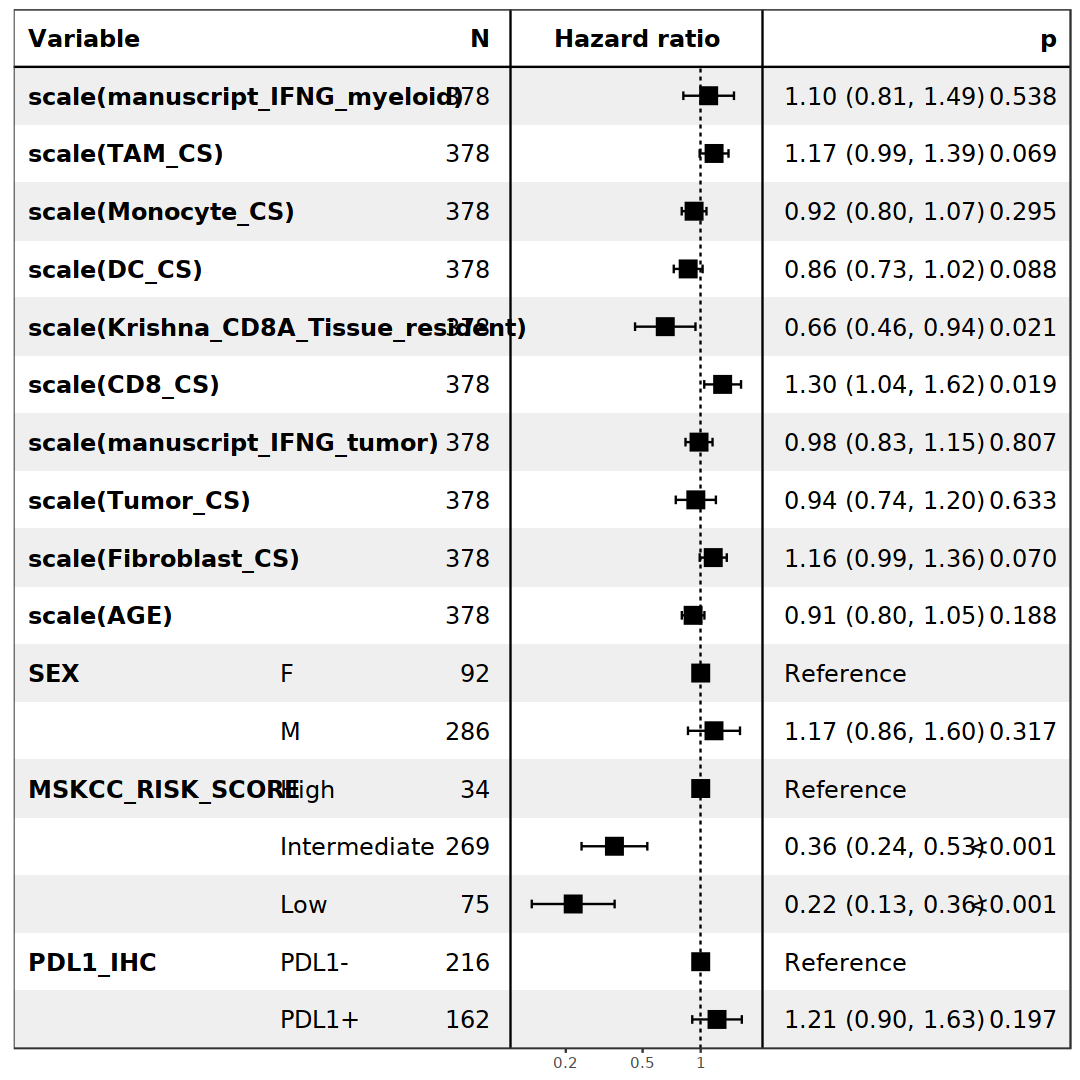

In [5]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
imm151_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_plot

### JAV101

In [6]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

,Var1,Freq
,<fct>,<int>
14682,CD8A,2
17979,Eosinophils,2
21236,IFIT3,2
27495,Neutrophils,2



 CB NCB 
182 161 

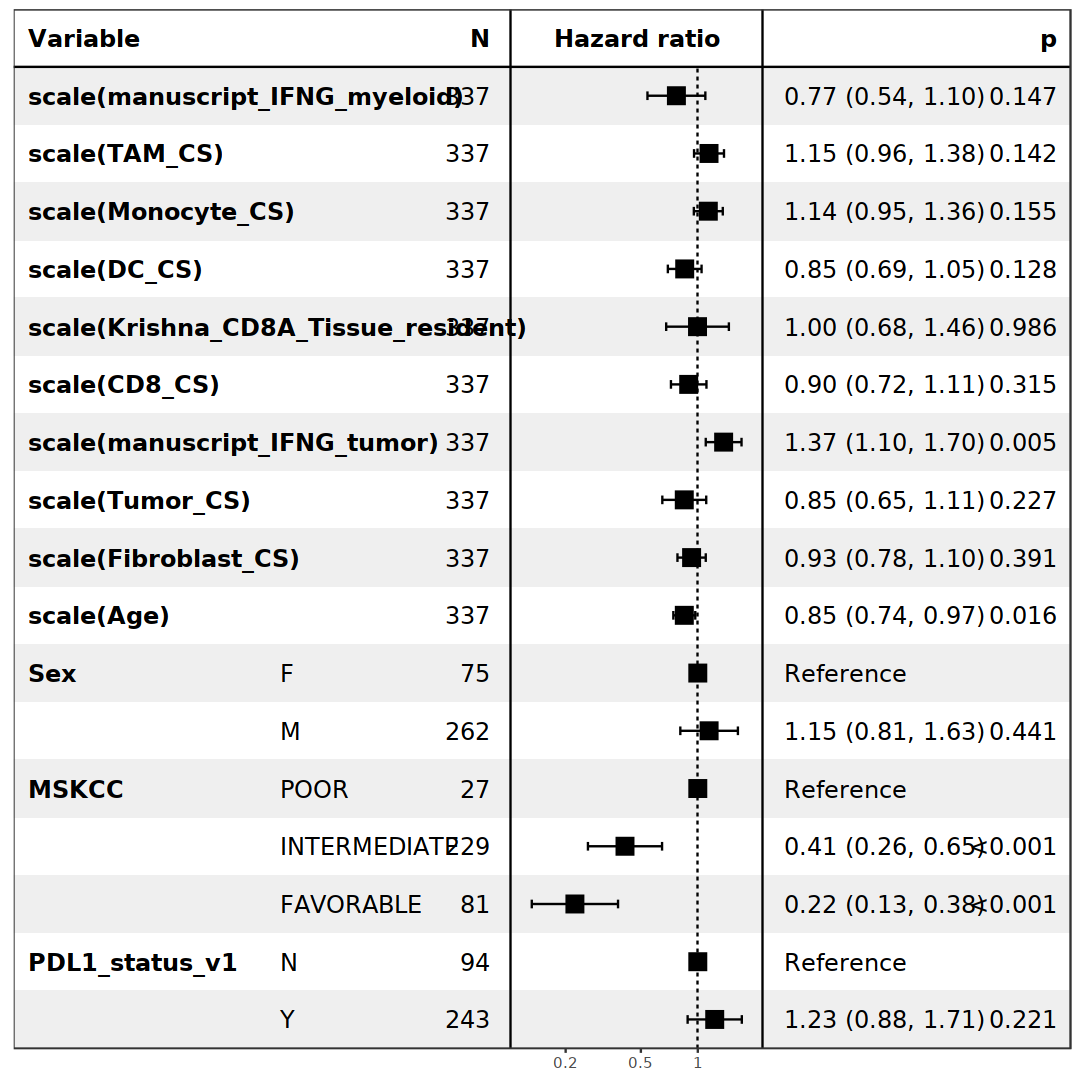

In [7]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
jav101_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_plot

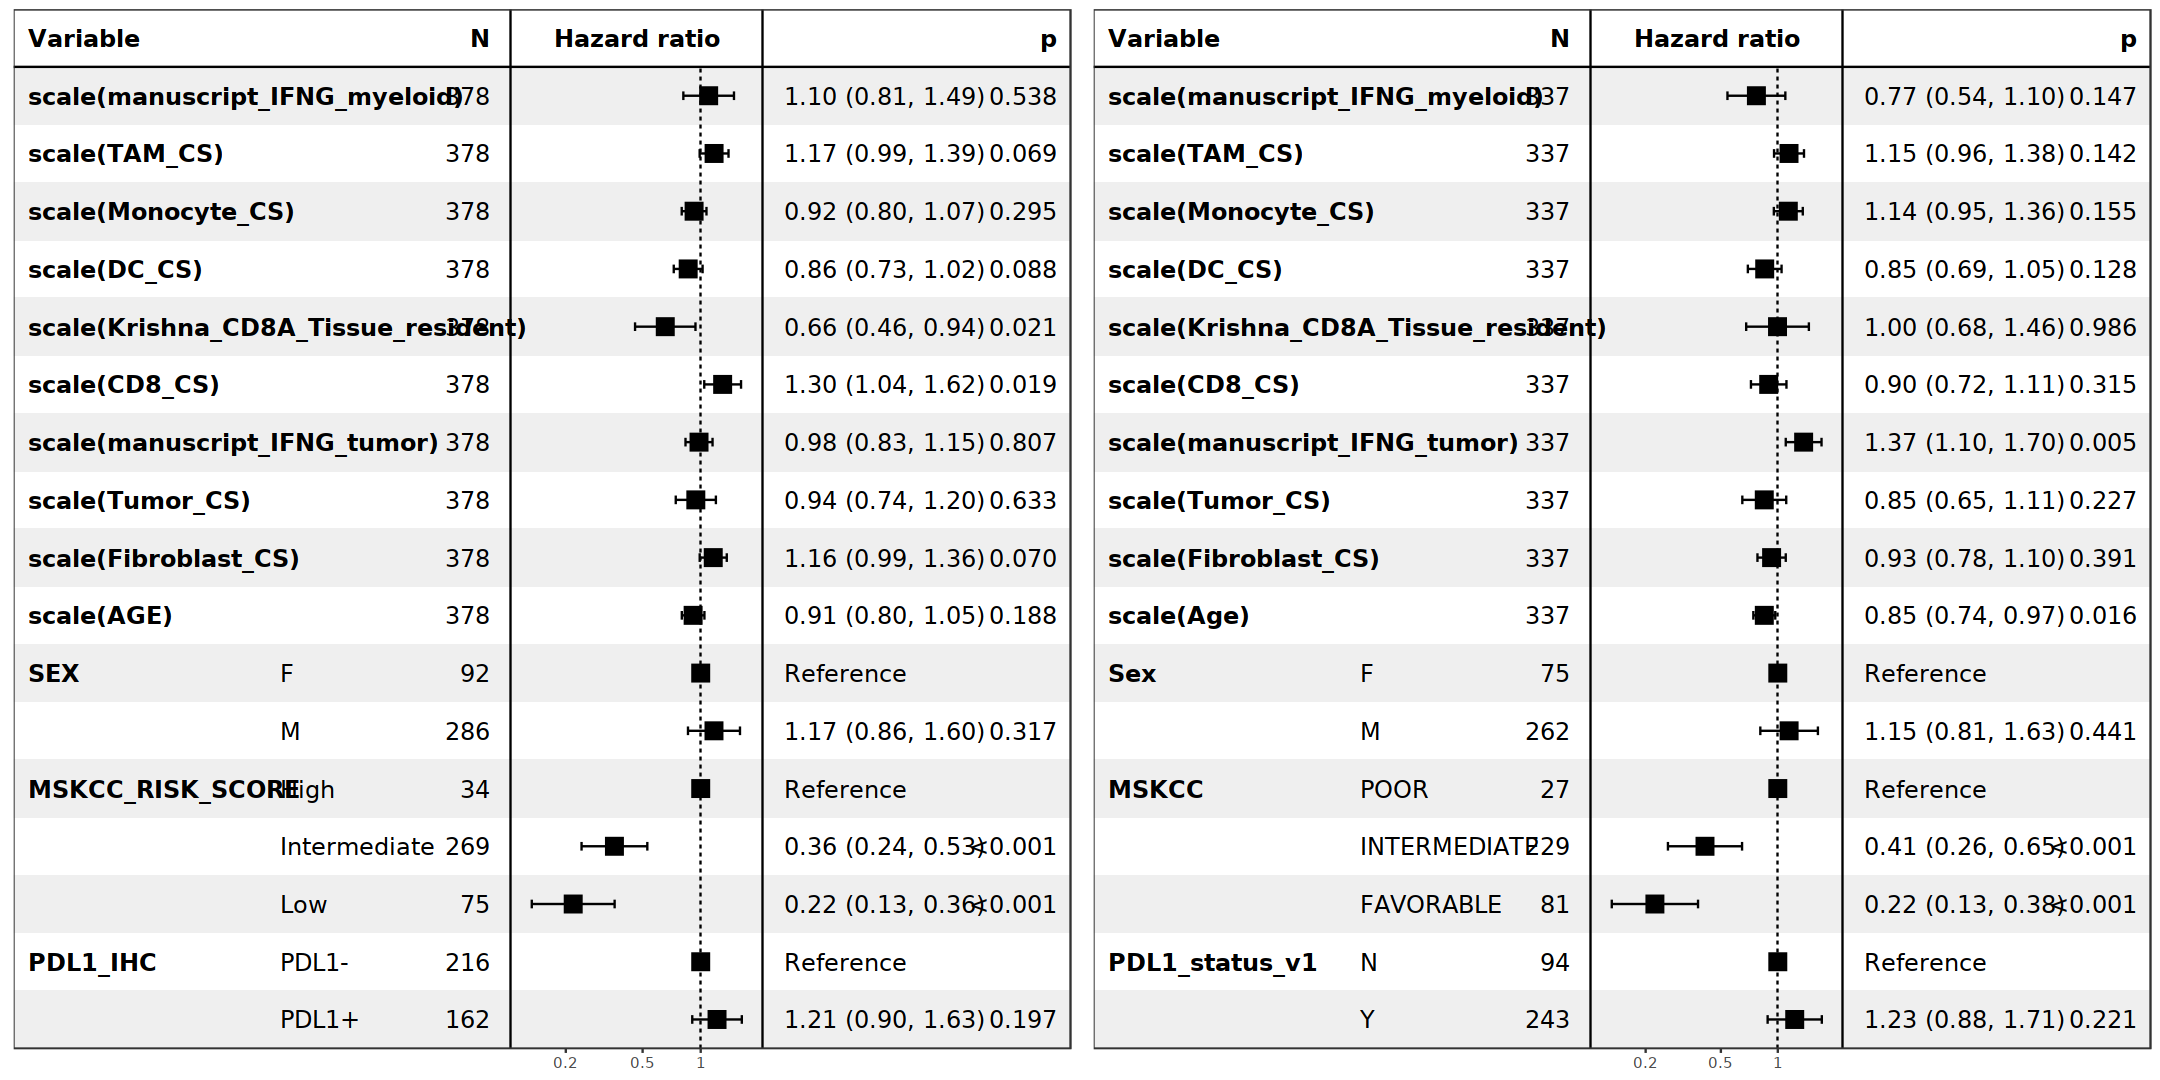

In [8]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures/Supp_Figure8_9/Supp_Figure8A_B_Cox_IMM151_JAV101_TKI_Scaled.pdf",width = 18, height = 9)

### Supp Figure 8C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (IFNG signatures) <a name="2"></a>

In [9]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2325  -1.1404   0.6472   0.8710   1.6772  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                          0.69135    0.40248   1.718   0.0858 .
scale(manuscript_IFNG_myeloid)      -0.57556    0.24457  -2.353   0.0186 *
scale(TAM_CS)                       -0.18354    0.15939  -1.152   0.2495  
scale(Monocyte_CS)                   0.07020    0.15436   0.455   0.6492  
scale(DC_CS)                         0.02477    0.15278   0.162   0.8712  
scale(Krishna_CD8A_Tissue_resident)  0.67831    0.30746   2.2

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid),4.445117,1,2.108345
scale(TAM_CS),1.902452,1,1.379294
scale(Monocyte_CS),1.778382,1,1.333560
scale(DC_CS),1.311711,1,1.145299
scale(Krishna_CD8A_Tissue_resident),7.044035,1,2.654060
scale(CD8_CS),2.592113,1,1.610004
scale(manuscript_IFNG_tumor),1.738804,1,1.318637
scale(Tumor_CS),4.863467,1,2.205327
scale(Fibroblast_CS),1.966291,1,1.402245
scale(AGE),1.150244,1,1.072494


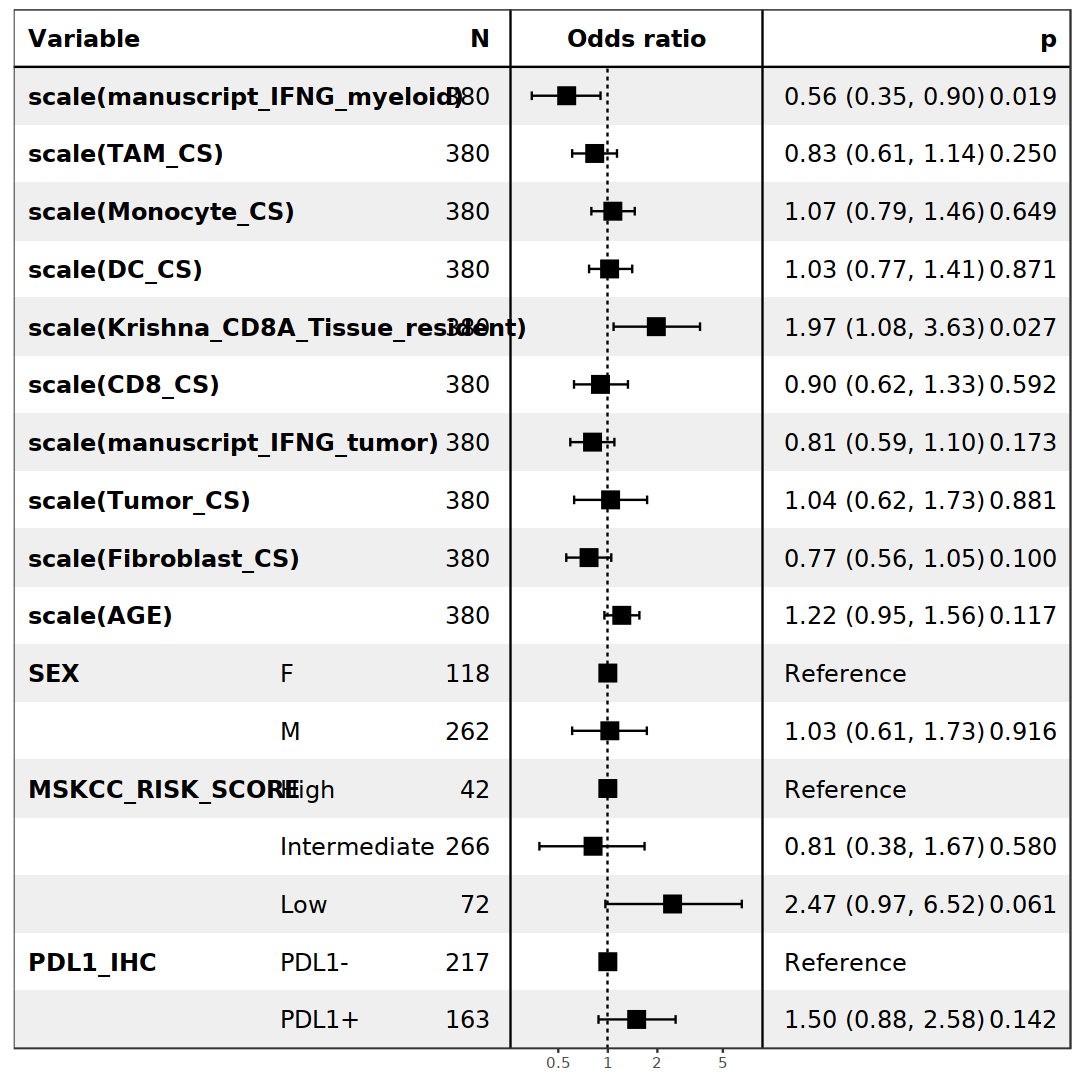

In [10]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

imm151_plot = forest_model(mylogit, panels,recalculate_width = F)
imm151_plot

### JAV101


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3615  -0.9608   0.6215   0.8209   1.7397  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.614522   0.466390  -1.318 0.187632    
scale(manuscript_IFNG_myeloid)      -0.705695   0.322494  -2.188 0.028652 *  
scale(TAM_CS)                        0.121843   0.185568   0.657 0.511439    
scale(Monocyte_CS)                   0.103238   0.165753   0.623 0.533388    
scale(DC_CS)                         0.001095   0.151486   0.007 0.994232    
scale(Krishna_CD8A_Tissue_resident)  0.713462   

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid),6.334491,1,2.516842
scale(TAM_CS),1.945903,1,1.394956
scale(Monocyte_CS),1.608539,1,1.268282
scale(DC_CS),1.423300,1,1.193022
scale(Krishna_CD8A_Tissue_resident),7.737760,1,2.781683
scale(CD8_CS),1.786839,1,1.336727
scale(manuscript_IFNG_tumor),2.168167,1,1.472470
scale(Tumor_CS),3.635668,1,1.906743
scale(Fibroblast_CS),2.053535,1,1.433016
scale(Age),1.054531,1,1.026903


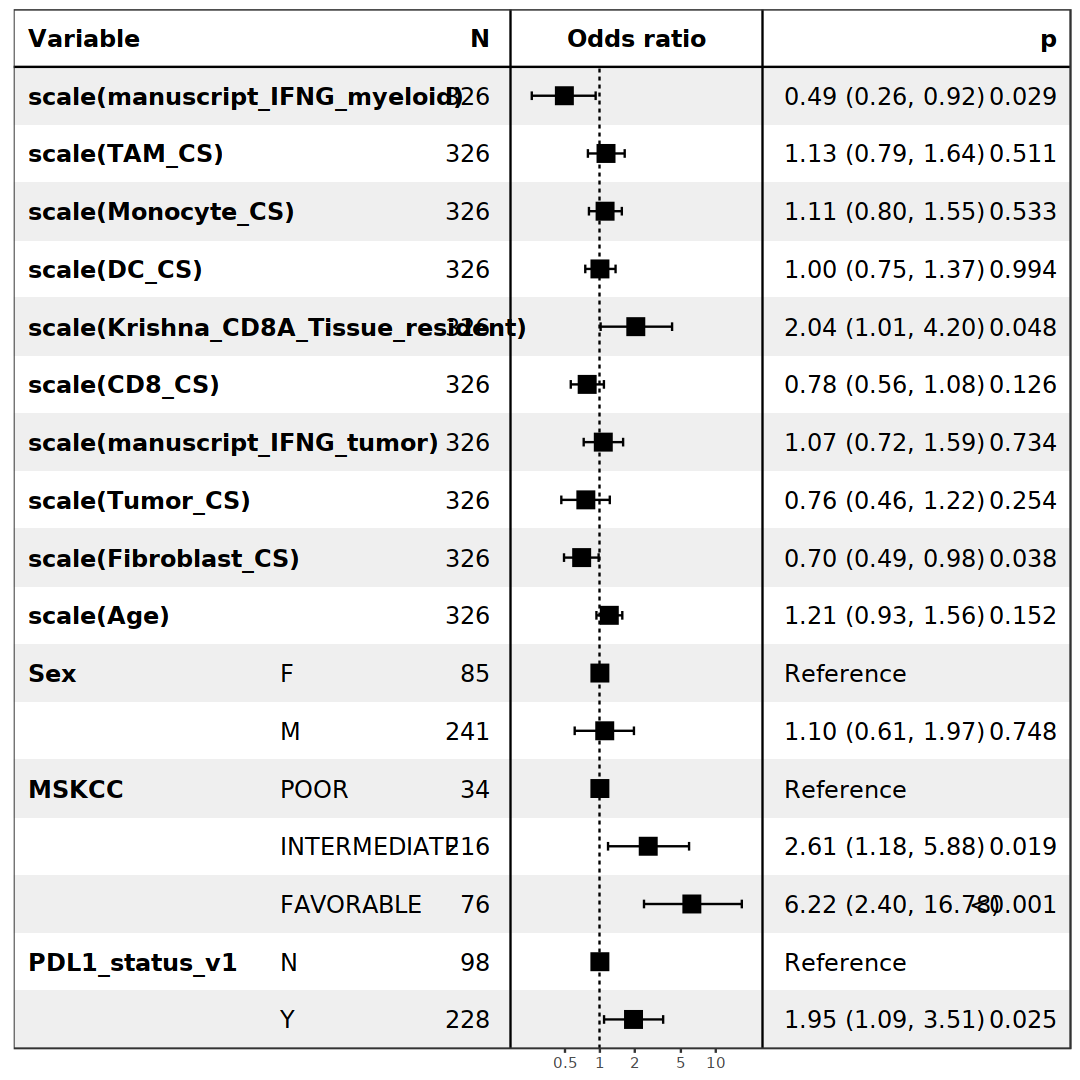

In [11]:
options(repr.plot.width=9, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

jav101_plot = forest_model(mylogit, panels,recalculate_width = F)
jav101_plot

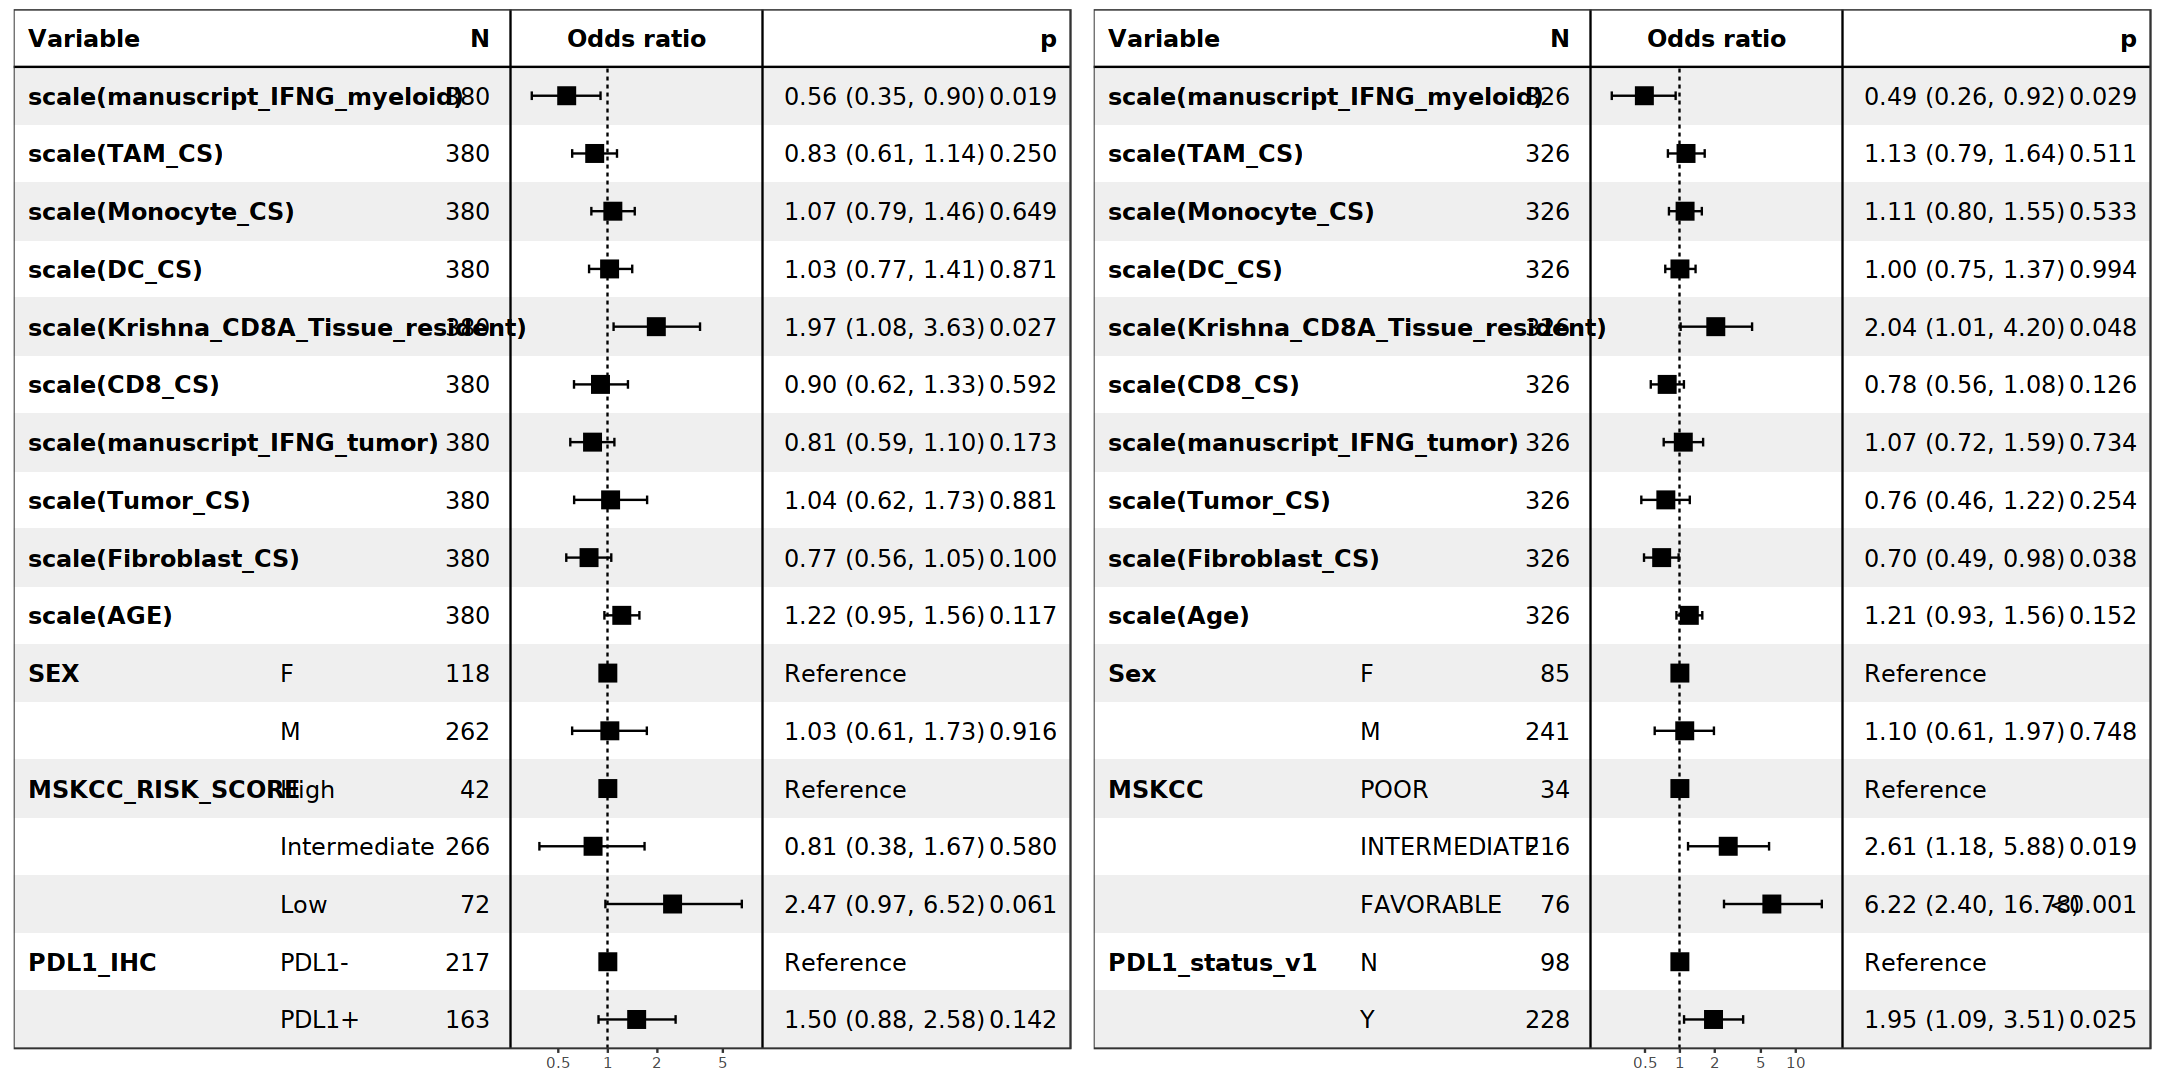

In [12]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures/Supp_Figure8_9/Supp_Figure8C_D_LogisticRegression_IMM151_JAV101_ICB_Scaled.pdf",width = 18, height = 9)

### Supp Figure 8E-F. Logistic regression models for CB vs NCB in TKI arm of IMM151 and JAV101 (IFNG signatures) <a name="3"></a>

In [13]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151


 CB NCB 
255 123 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3297  -0.9228   0.6007   0.8122   2.1441  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.04204    0.49350  -2.112   0.0347 *  
scale(manuscript_IFNG_myeloid)       0.33919    0.26935   1.259   0.2079    
scale(TAM_CS)                       -0.25851    0.16367  -1.579   0.1142    
scale(Monocyte_CS)                  -0.14346    0.14801  -0.969   0.3324    
scale(DC_CS)                         0.04244    0.15407   0.275   0.7830    
scale(Krishna_CD8A_Tissue_resident)  0.40702    0

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid),5.166212,1,2.272930
scale(TAM_CS),1.827928,1,1.352009
scale(Monocyte_CS),1.518255,1,1.232175
scale(DC_CS),1.511061,1,1.229252
scale(Krishna_CD8A_Tissue_resident),7.383252,1,2.717214
scale(CD8_CS),3.058204,1,1.748772
scale(manuscript_IFNG_tumor),1.611038,1,1.269267
scale(Tumor_CS),3.994240,1,1.998560
scale(Fibroblast_CS),1.826647,1,1.351535
scale(AGE),1.077922,1,1.038230


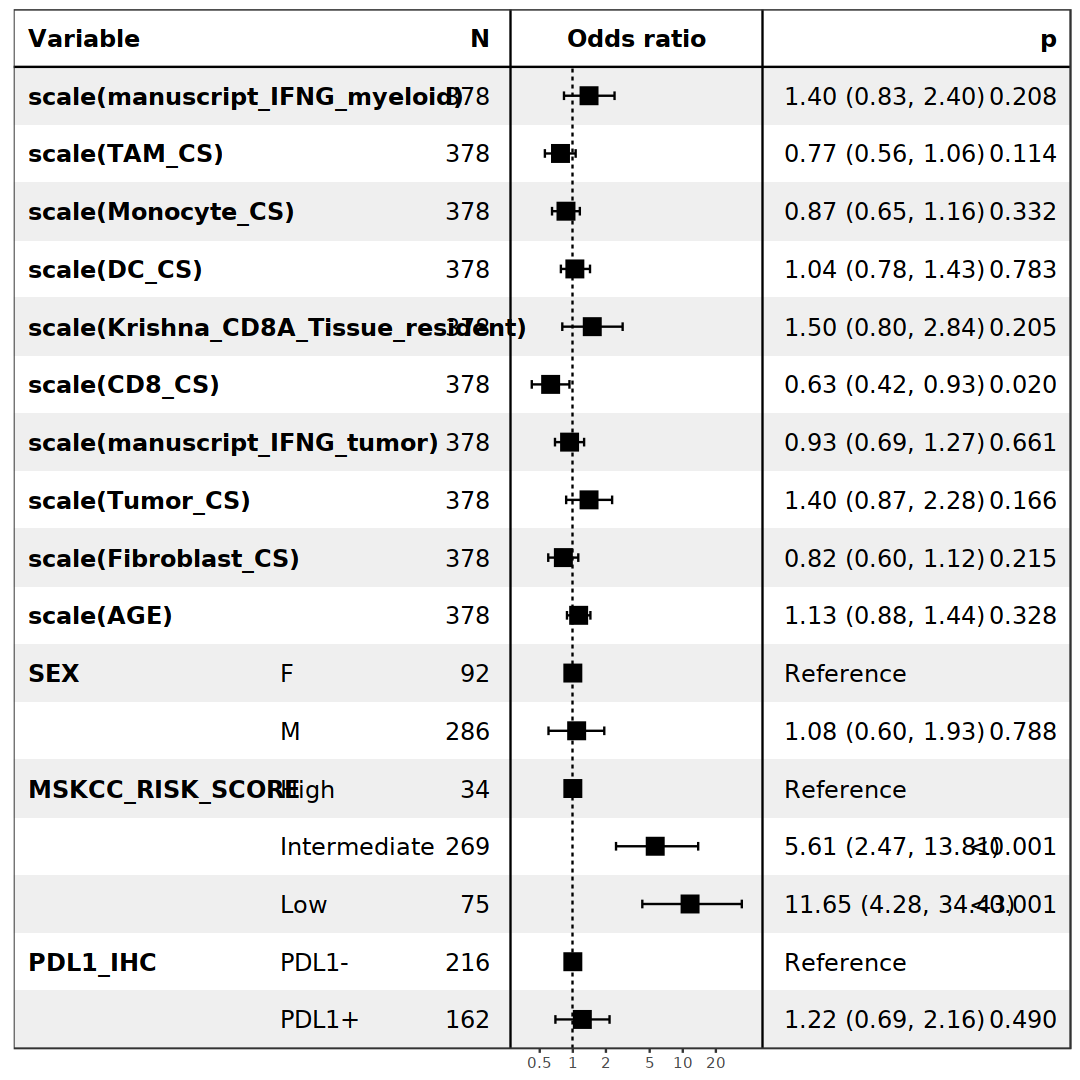

In [14]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

imm151_plot = forest_model(mylogit, panels,recalculate_width = F)
imm151_plot

### JAV101


 CB NCB 
182 161 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9696  -1.1414   0.6366   1.0943   1.9742  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.17963    0.55557  -2.123 0.033731 *  
scale(manuscript_IFNG_myeloid)       0.26436    0.30078   0.879 0.379435    
scale(TAM_CS)                       -0.06943    0.14754  -0.471 0.637939    
scale(Monocyte_CS)                  -0.11769    0.14534  -0.810 0.418098    
scale(DC_CS)                         0.31076    0.15766   1.971 0.048717 *  
scale(Krishna_CD8A_Tissue_resident)  0.05078    0.3230

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid),6.698067,1,2.588062
scale(TAM_CS),1.654561,1,1.286297
scale(Monocyte_CS),1.655209,1,1.286549
scale(DC_CS),1.402567,1,1.184300
scale(Krishna_CD8A_Tissue_resident),7.716976,1,2.777945
scale(CD8_CS),1.877638,1,1.370269
scale(manuscript_IFNG_tumor),2.008667,1,1.417274
scale(Tumor_CS),3.389869,1,1.841160
scale(Fibroblast_CS),1.685421,1,1.298238
scale(Age),1.029677,1,1.014730


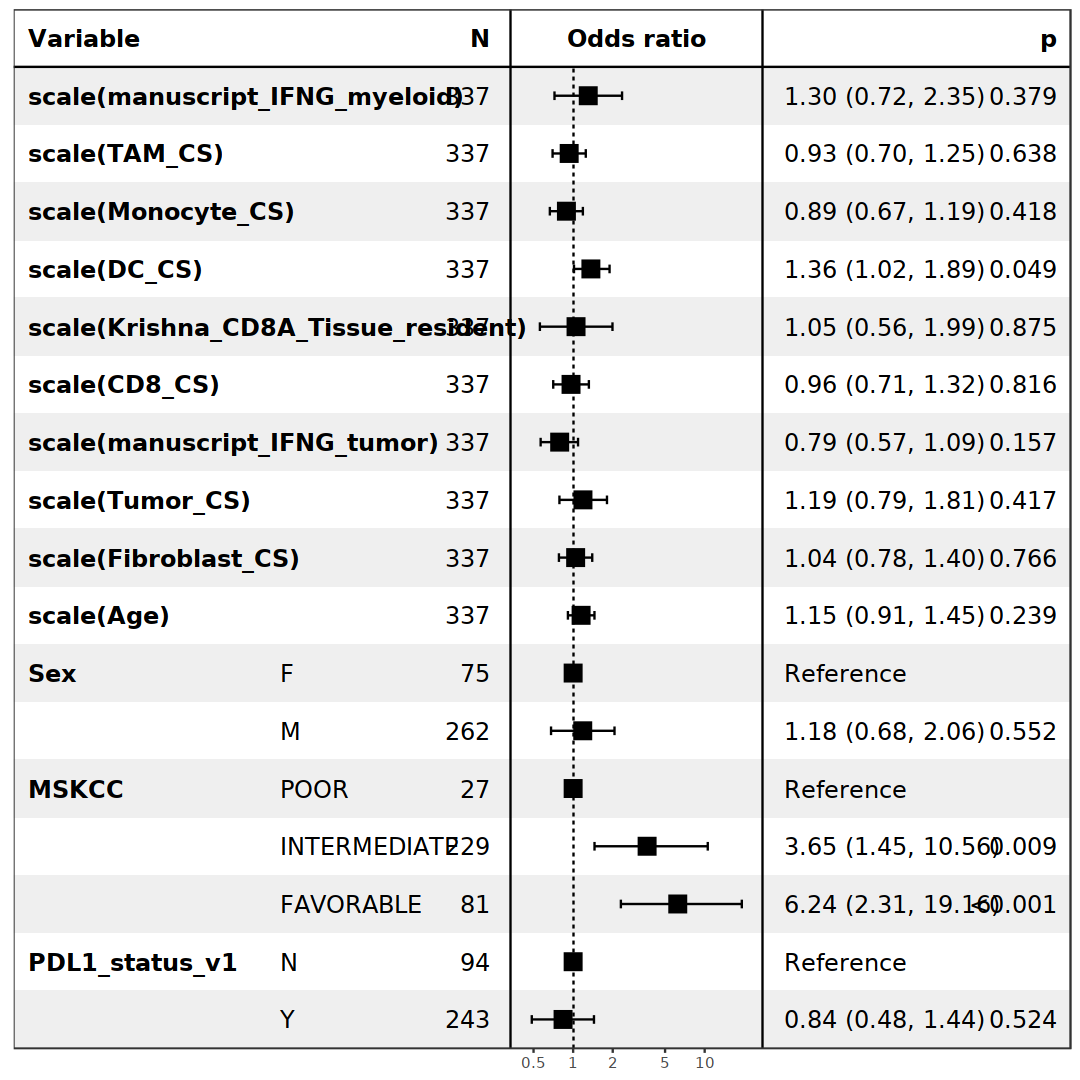

In [15]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

jav101_plot = forest_model(mylogit, panels,recalculate_width = F)
jav101_plot

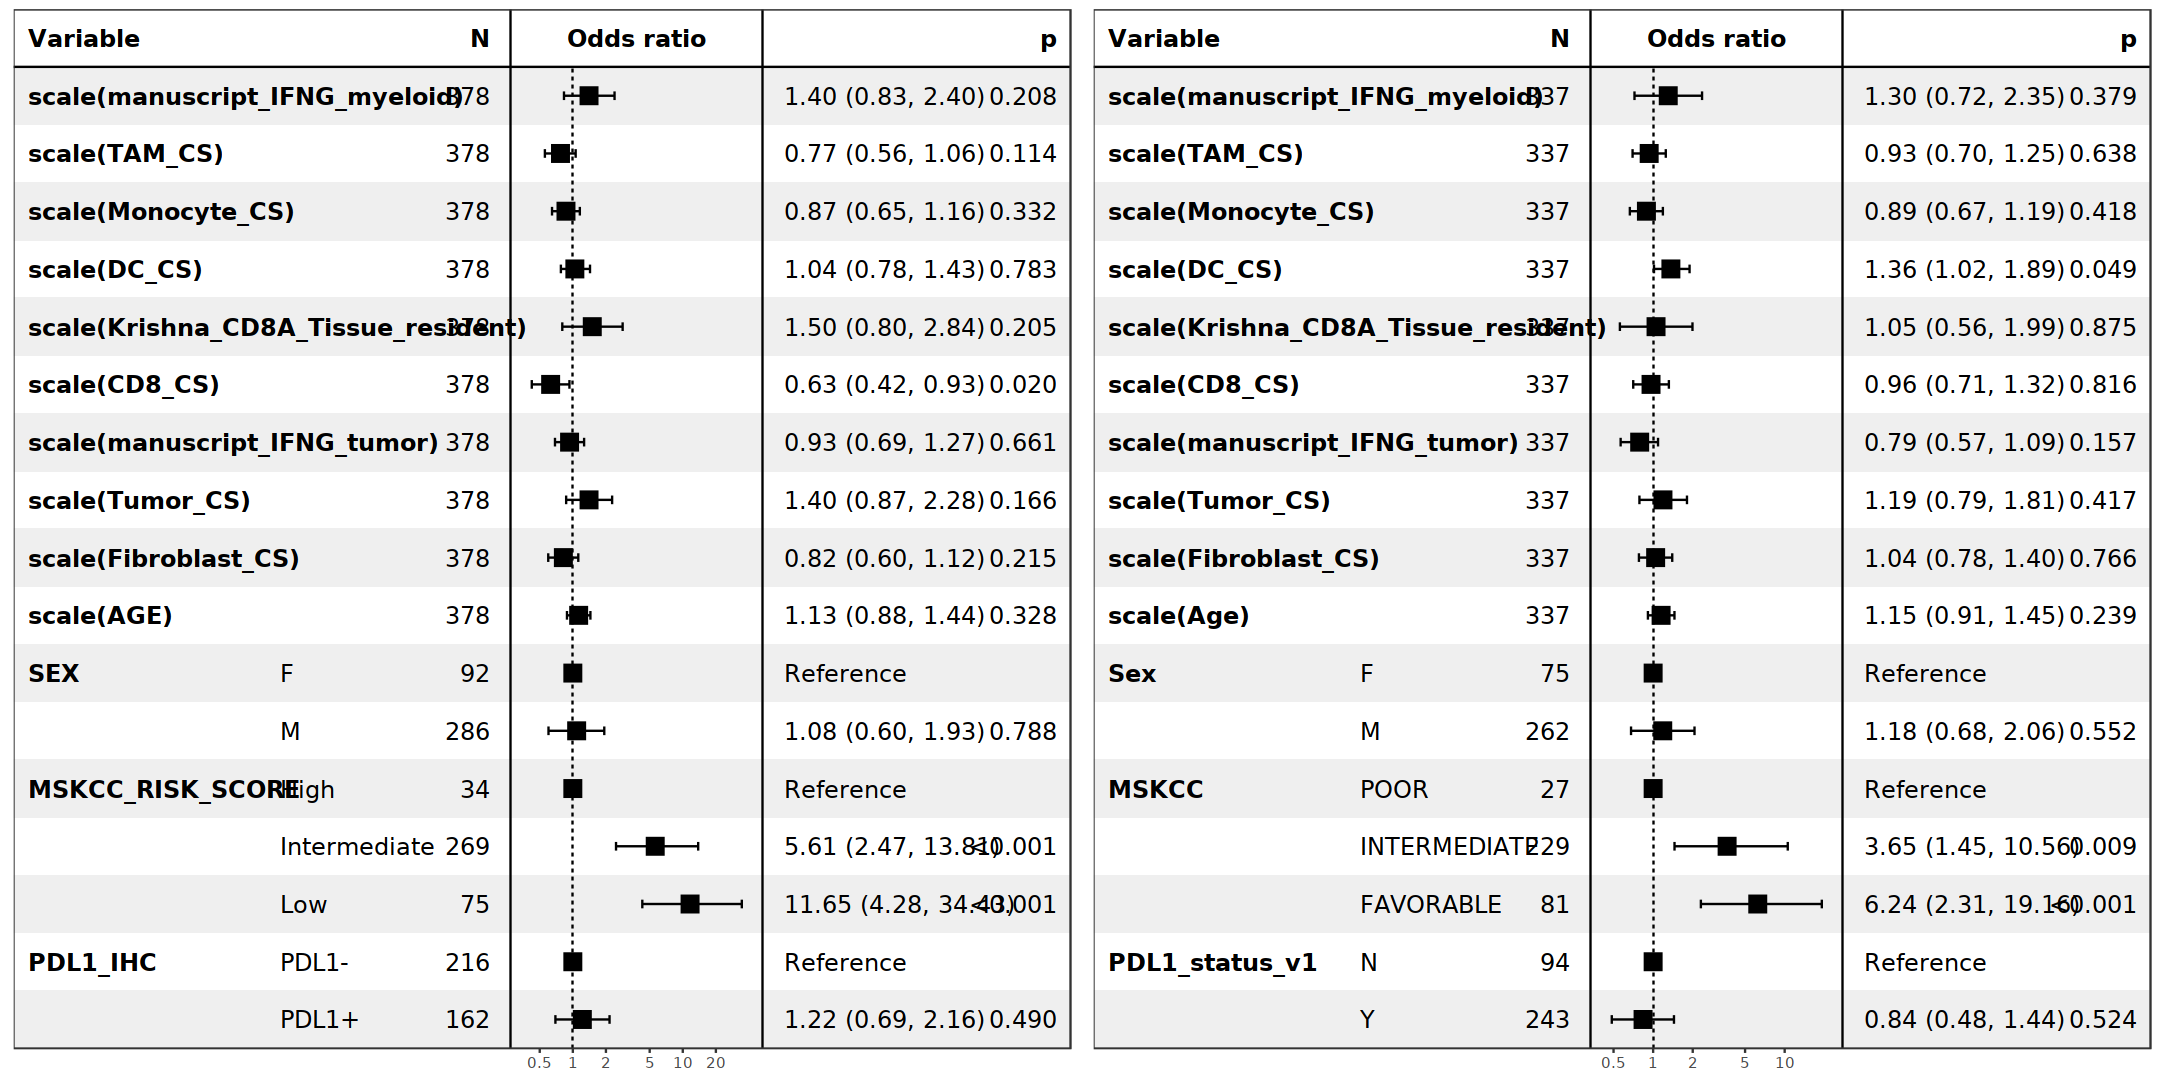

In [16]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_plot, jav101_plot)

ggsave("../../Supp_Figures/Supp_Figure8_9/Supp_Figure8E_F_LogisticRegeression_IMM151_JAV101_TKI_Scaled.pdf",width = 18, height = 9)

### Supp Figure 9A-B. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Krishna_CD8A_Tissue_resident-high samples, stratified myeloid IFNG signaling) <a name="4"></a>

In [17]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [18]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

In [19]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
255 123 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score 

,cutpoint,statistic
,<dbl>,<dbl>
Krishna_CD8A_Tissue_resident,-4.336211,3.127211


$Krishna_CD8A_Tissue_resident


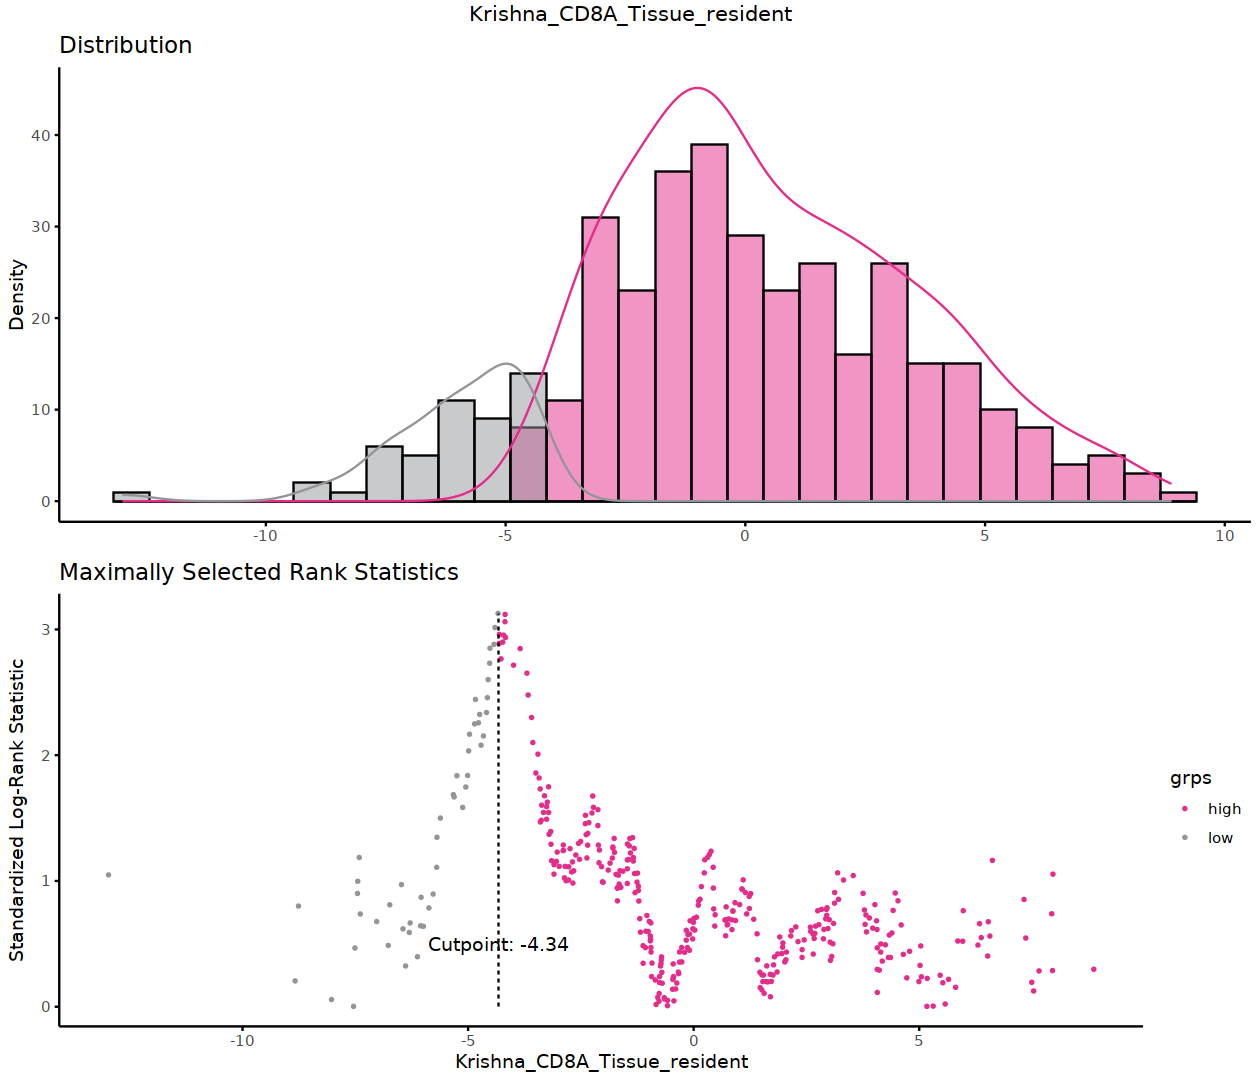

In [20]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(atezo_bev, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [21]:
atezo_bev_topcd8 = subset(atezo_bev, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(atezo_bev_topcd8)

[1]   331 25639

In [22]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   342 25639

,cutpoint,statistic
,<dbl>,<dbl>
manuscript_IFNG_myeloid,-1.879233,3.637437


$manuscript_IFNG_myeloid


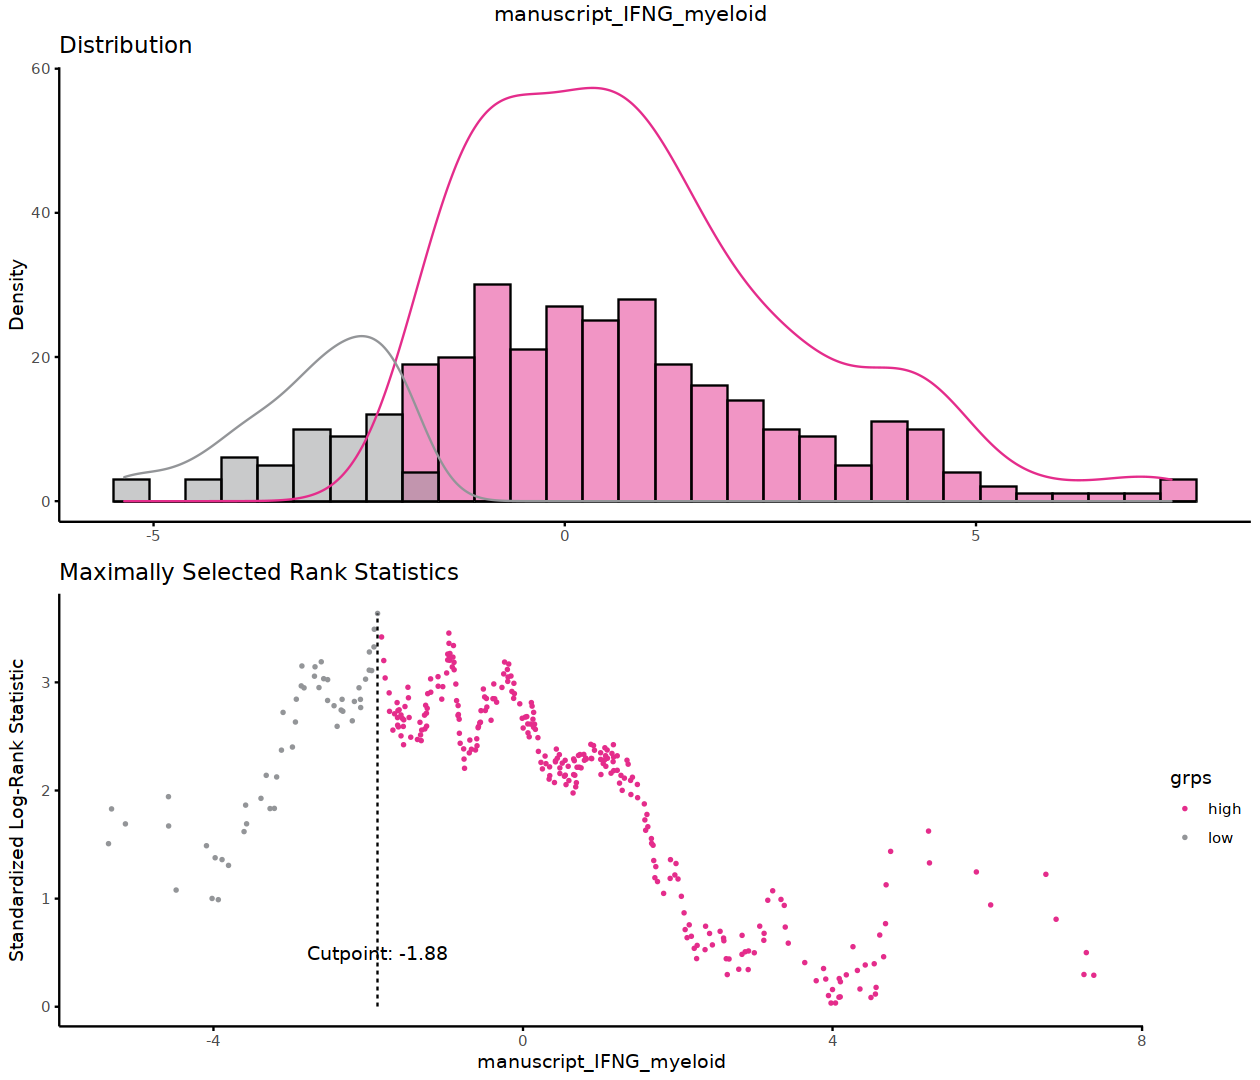

In [23]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(atezo_bev_topcd8, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [24]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

,PFS_MONTHS,PFS_CENSOR,manuscript_IFNG_myeloid
,<dbl>,<lgl>,<chr>
EA-c98e425b64,11.43,TRUE,high
EA-50a17b762a,9.76,TRUE,high
EA-503b2e1876,11.24,FALSE,low
EA-9be3b7c254,23.39,FALSE,low
EA-cce8886053,2.07,TRUE,high
EA-858e45ba5f,11.17,TRUE,high


[1] 331   3


high  low 
 279   52 

In [25]:
res.cut_myeloid$cutpoint$cutpoint

[1] -1.879233

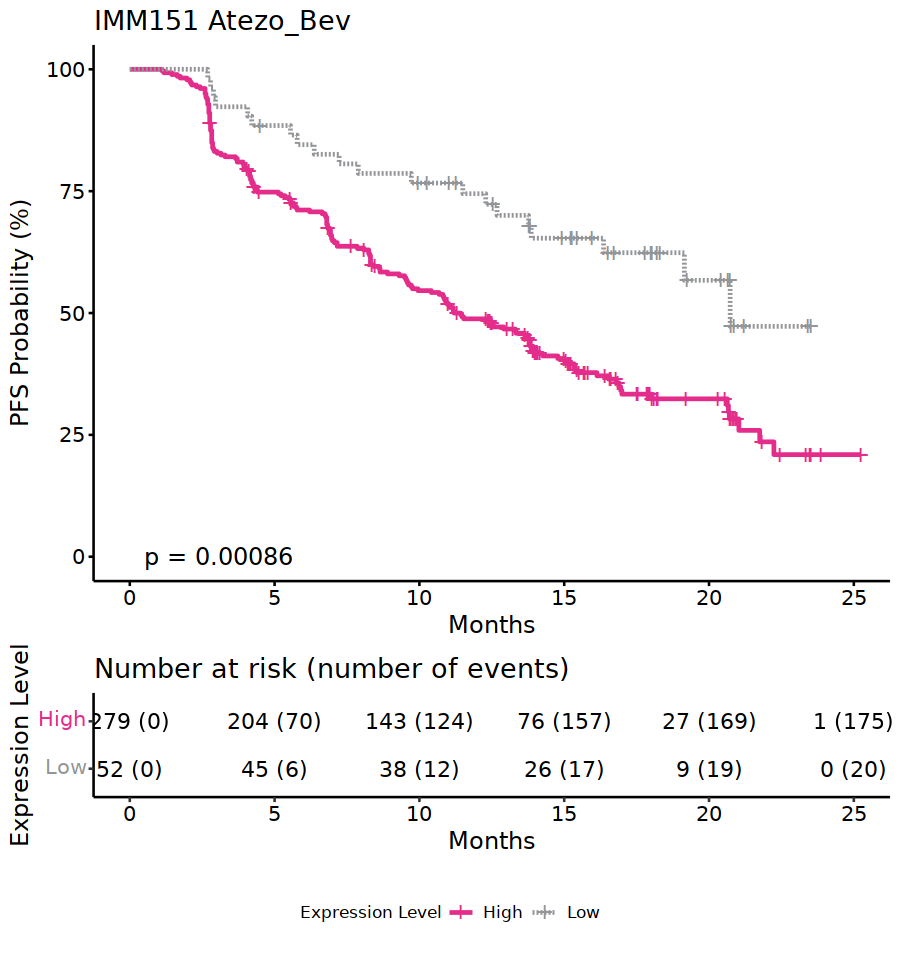

In [26]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "IMM151 Atezo_Bev",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
io

In [27]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 299   43 

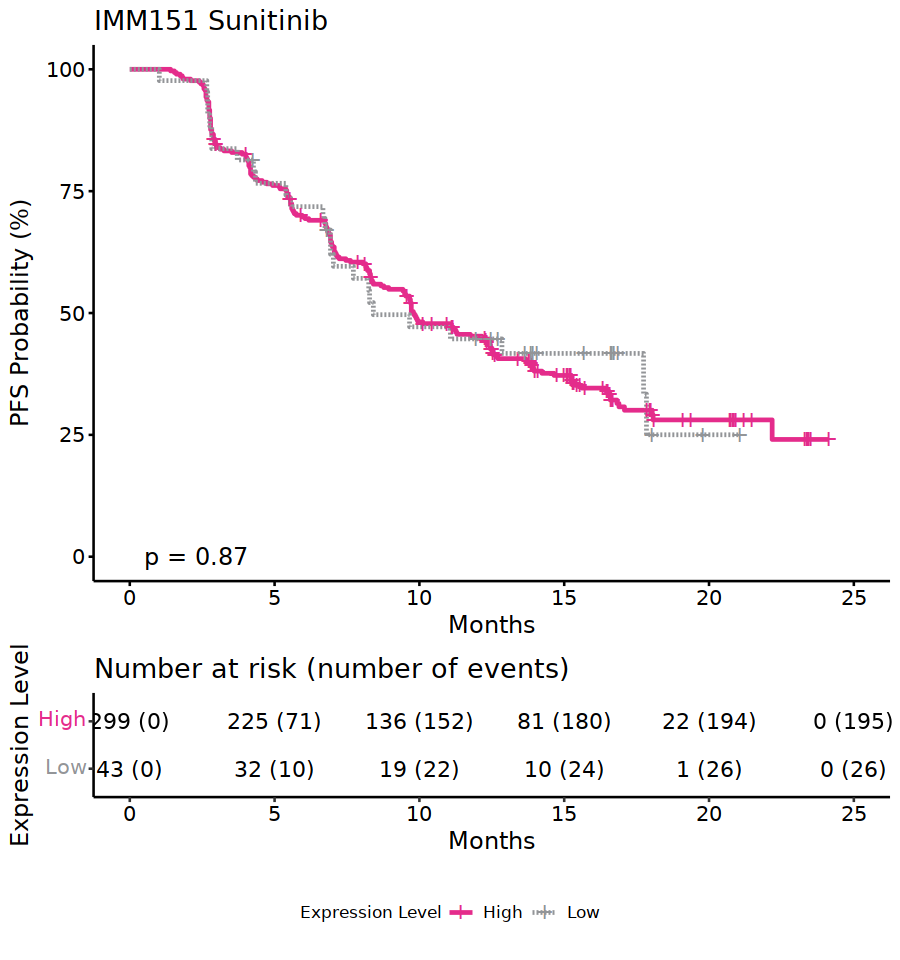

In [28]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "IMM151 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [29]:
setequal(row.names(res.cat), row.names(atezo_bev_topcd8))

[1] TRUE

In [30]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  52  279 

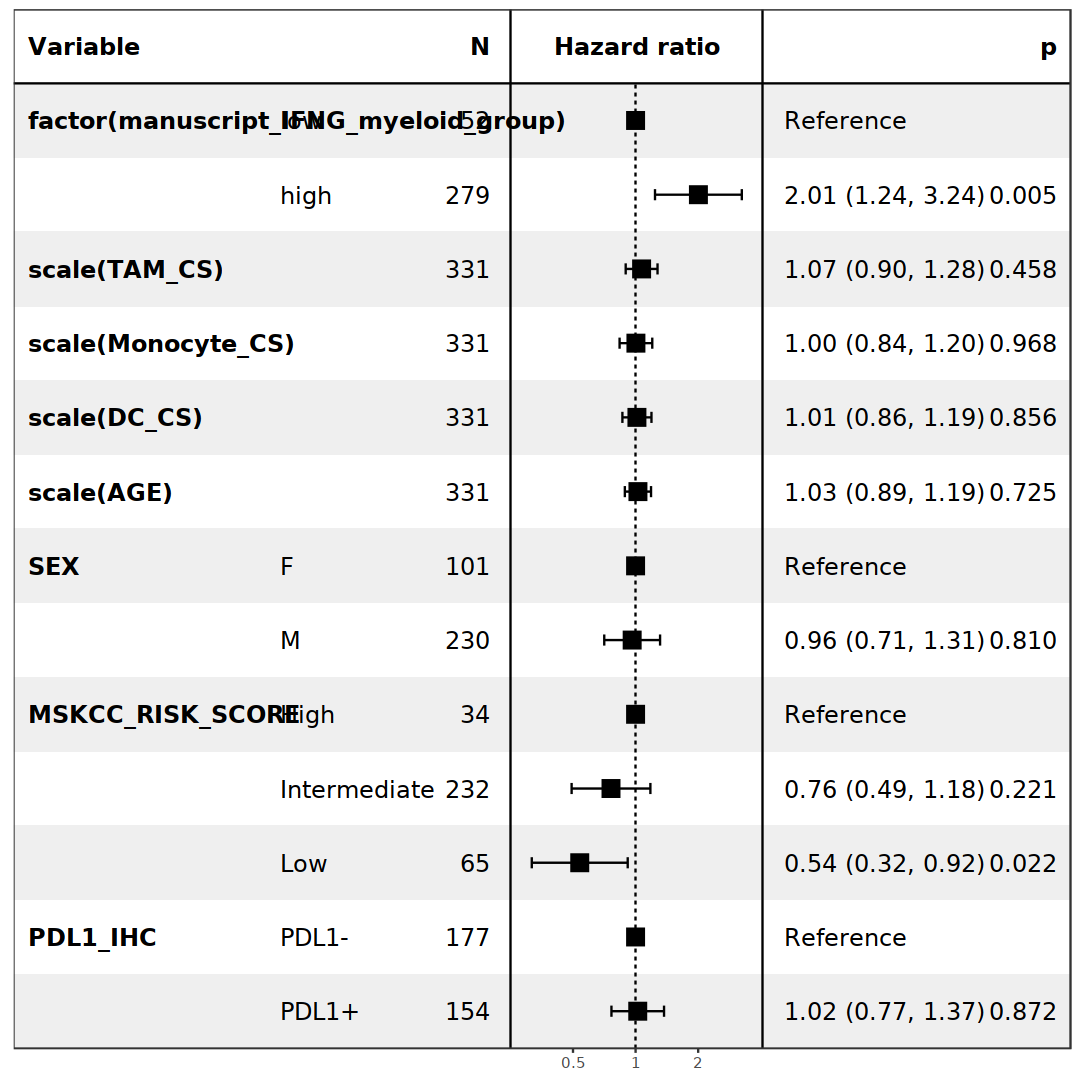

In [31]:
options(repr.plot.width=9, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
imm151_icb_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_icb_plot

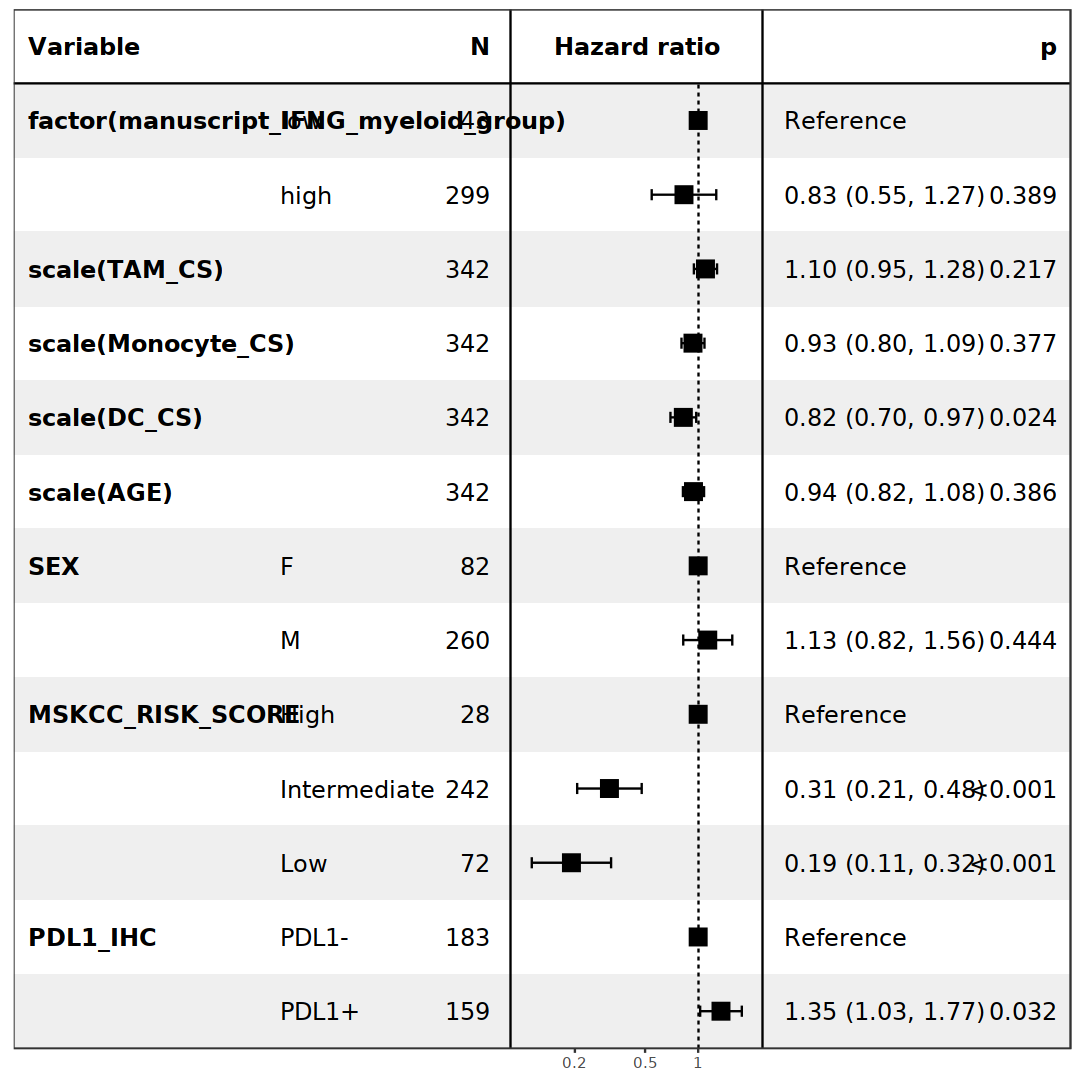

In [32]:
options(repr.plot.width=9, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib_topcd8)
imm151_tki_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_tki_plot

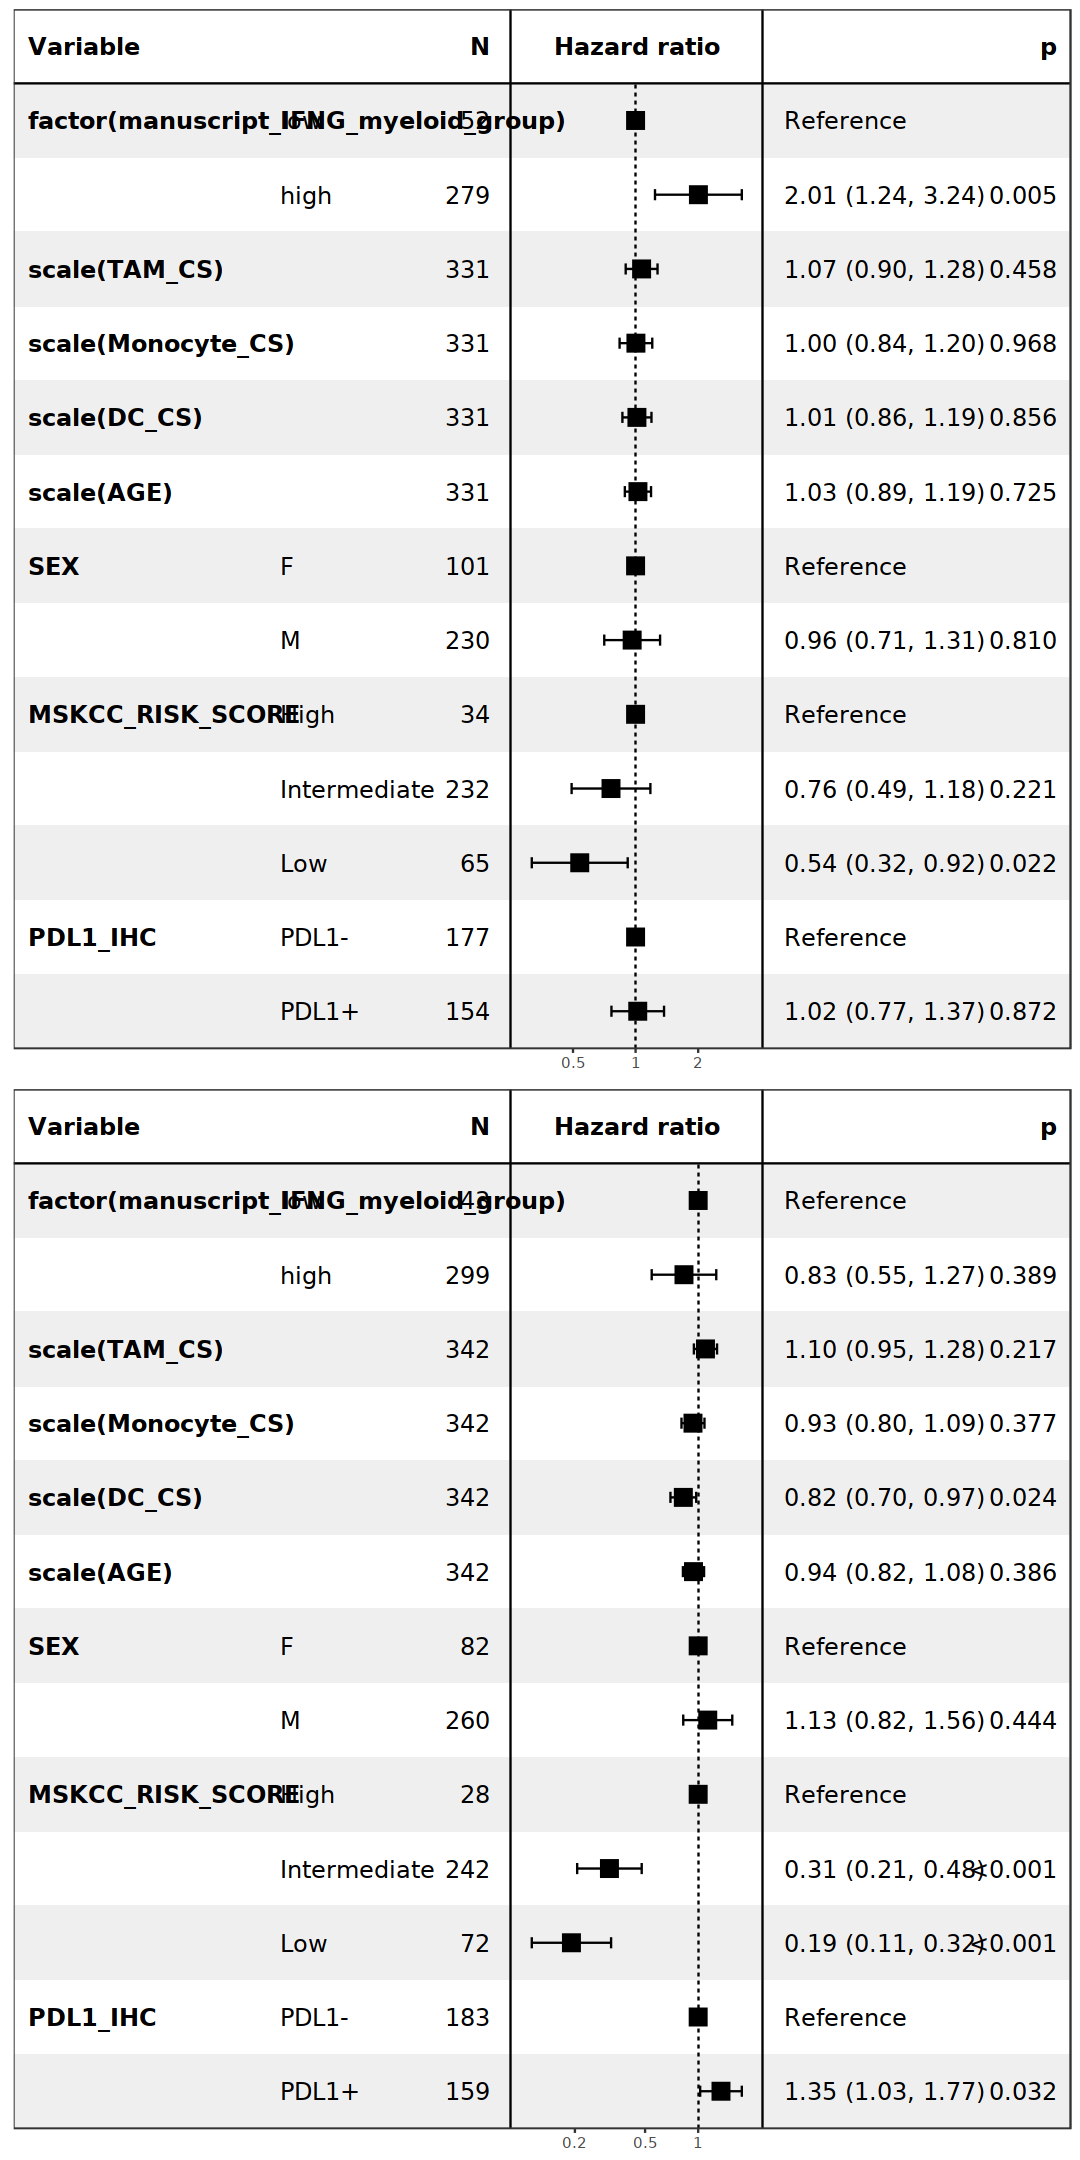

In [33]:
options(repr.plot.width=9, repr.plot.height=18)

ggarrange(imm151_icb_plot, imm151_tki_plot,ncol = 1)

ggsave("../../Supp_Figures/Supp_Figure8_9/Supp_Figure9A_B_Cox_CD8High_IMM151_ICB_TKI_Scaled.pdf",width = 9, height = 18)

### JAV101

In [34]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

In [35]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
182 161 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score

,cutpoint,statistic
,<dbl>,<dbl>
Krishna_CD8A_Tissue_resident,-2.855867,3.710634


$Krishna_CD8A_Tissue_resident


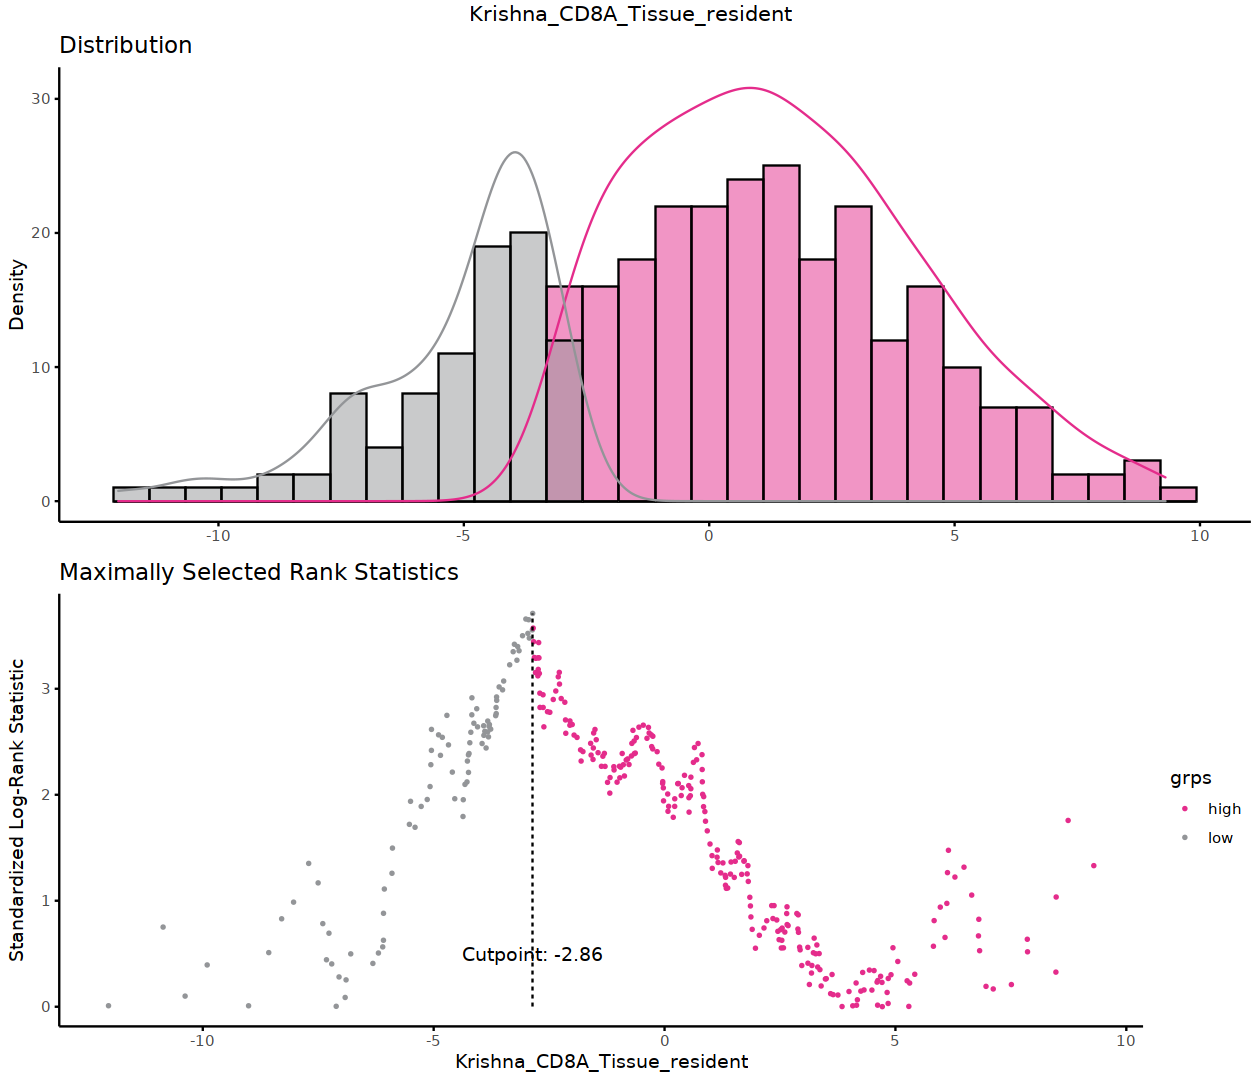

In [36]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(avel_axit, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [37]:
res.cut_cd8$cutpoint$cutpoint

[1] -2.855867

In [38]:
avel_axit_topcd8 = subset(avel_axit, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(avel_axit_topcd8)

[1]   245 40348

In [39]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   275 40348

,cutpoint,statistic
,<dbl>,<dbl>
manuscript_IFNG_myeloid,-1.283223,2.767251


$manuscript_IFNG_myeloid


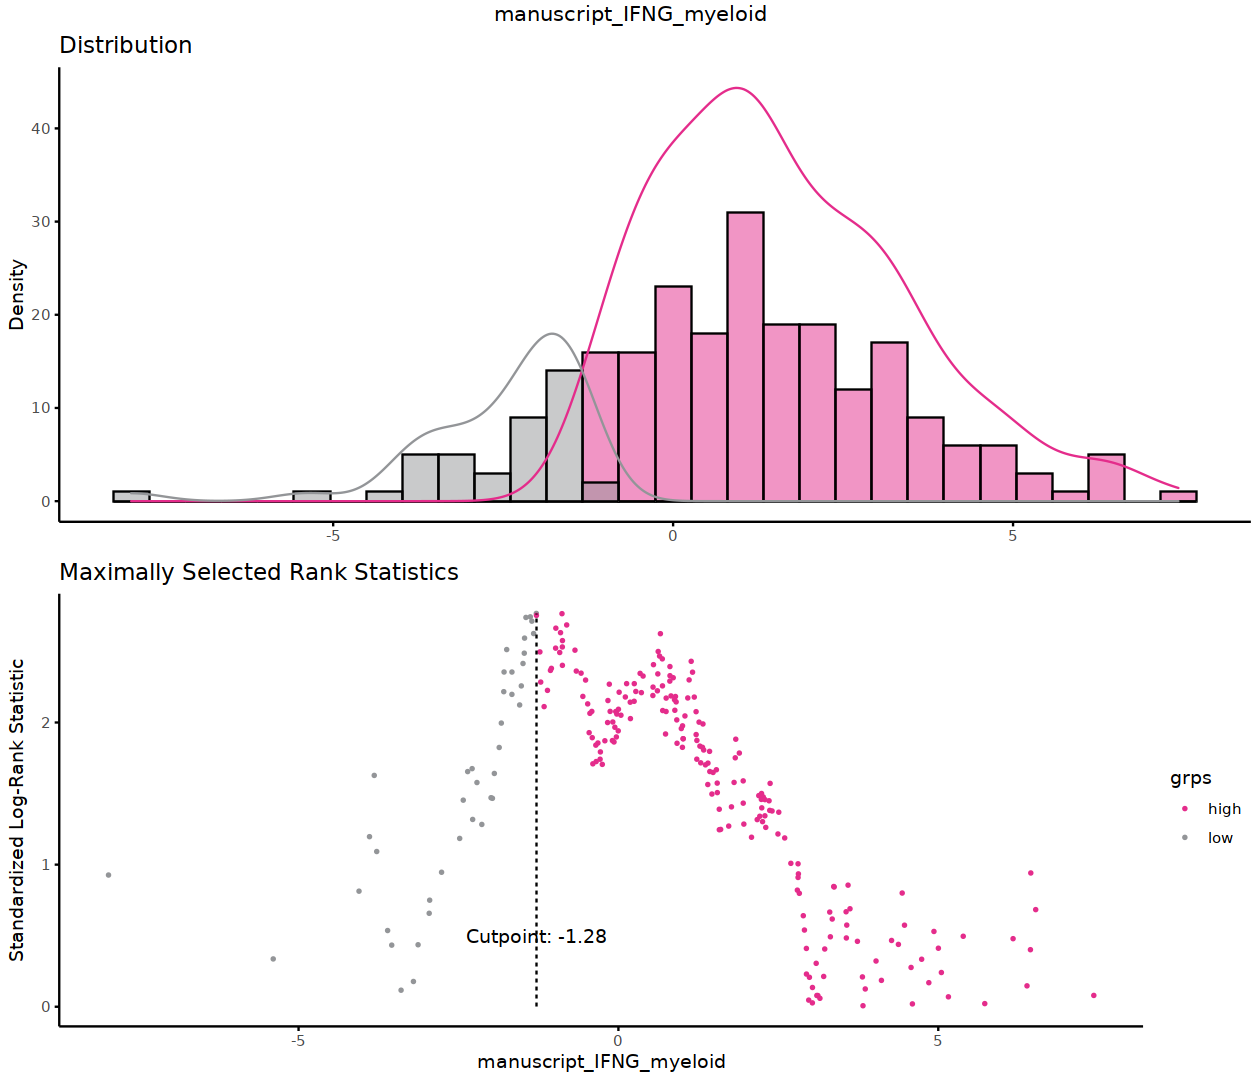

In [40]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(avel_axit_topcd8, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [41]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

,PFS,PFS_CNSR,manuscript_IFNG_myeloid
,<dbl>,<int>,<chr>
10011001_6203185783,1.379877,1,low
10011015_6204820848,2.891170,1,high
10011017_6204067222,18.135524,0,high
10011020_6204820845,1.412731,1,low
10011021_6204820844,3.318275,0,low
10011027_6204067225,2.891170,1,high


[1] 245   3


high  low 
 204   41 

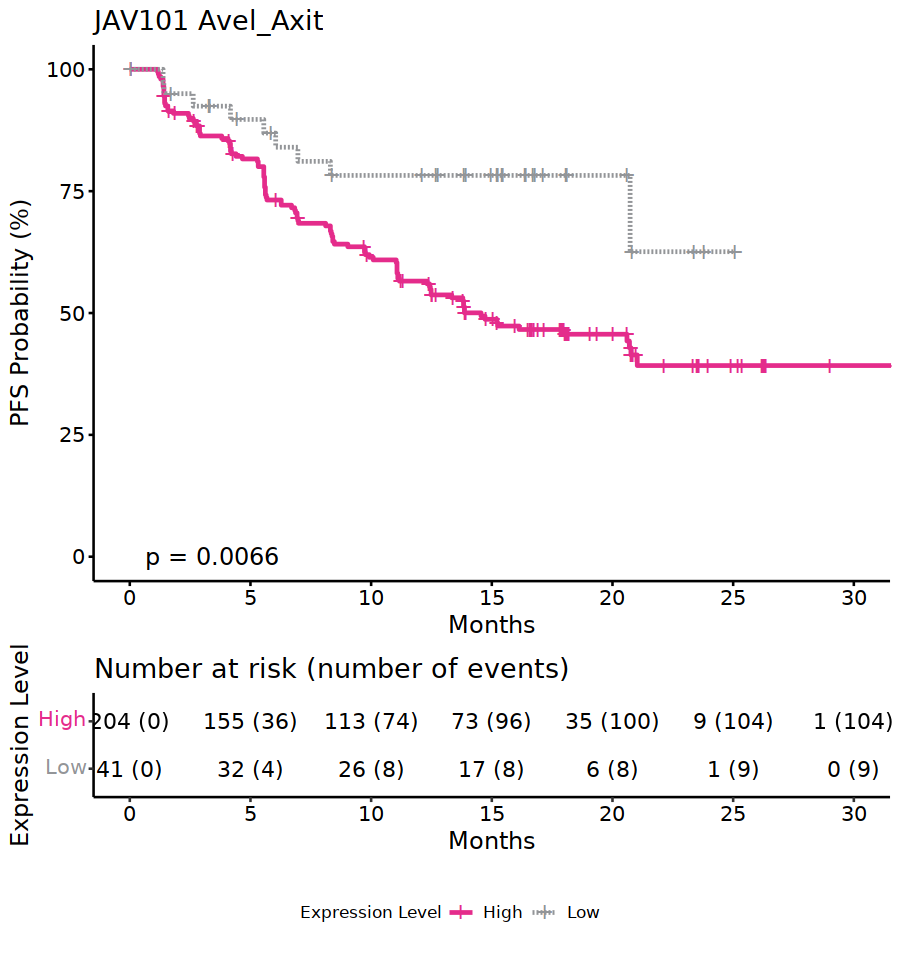

In [42]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "JAV101 Avel_Axit",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low"),
                break.x.by = 5
    )
io

In [43]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 235   40 

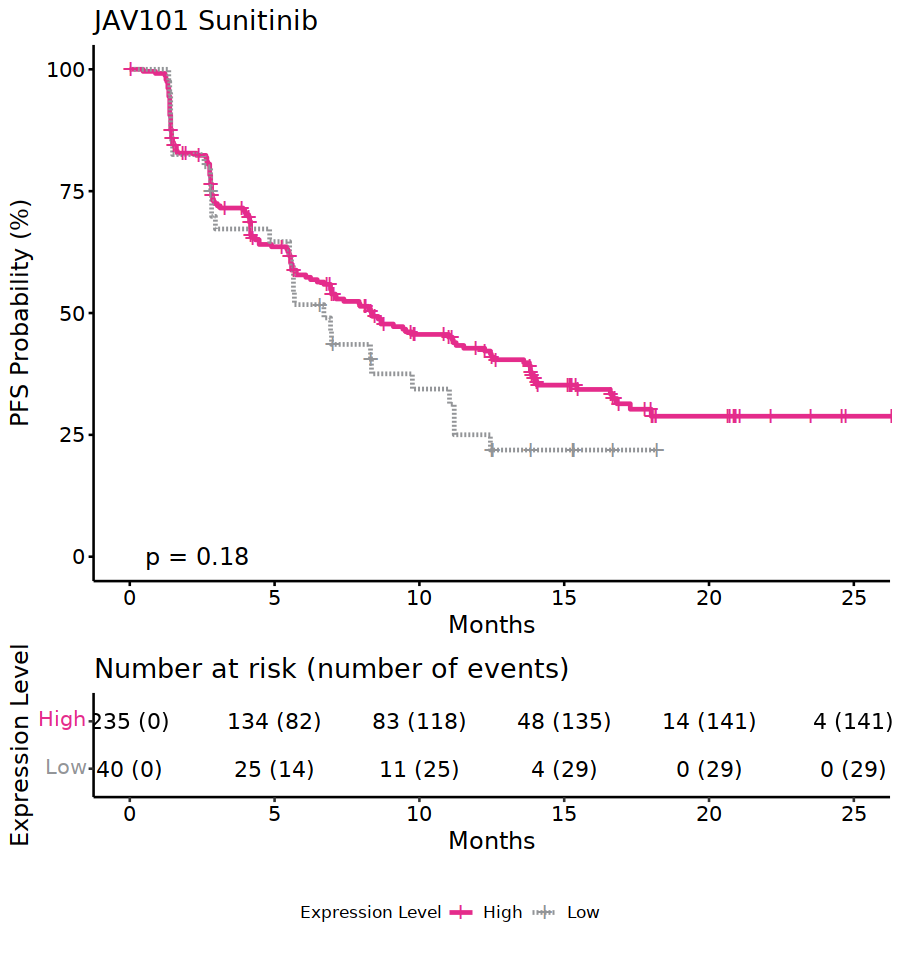

In [44]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "JAV101 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [45]:
setequal(row.names(res.cat), row.names(avel_axit_topcd8))

[1] TRUE

In [46]:
avel_axit_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
avel_axit_topcd8$manuscript_IFNG_myeloid_group = factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  41  204 

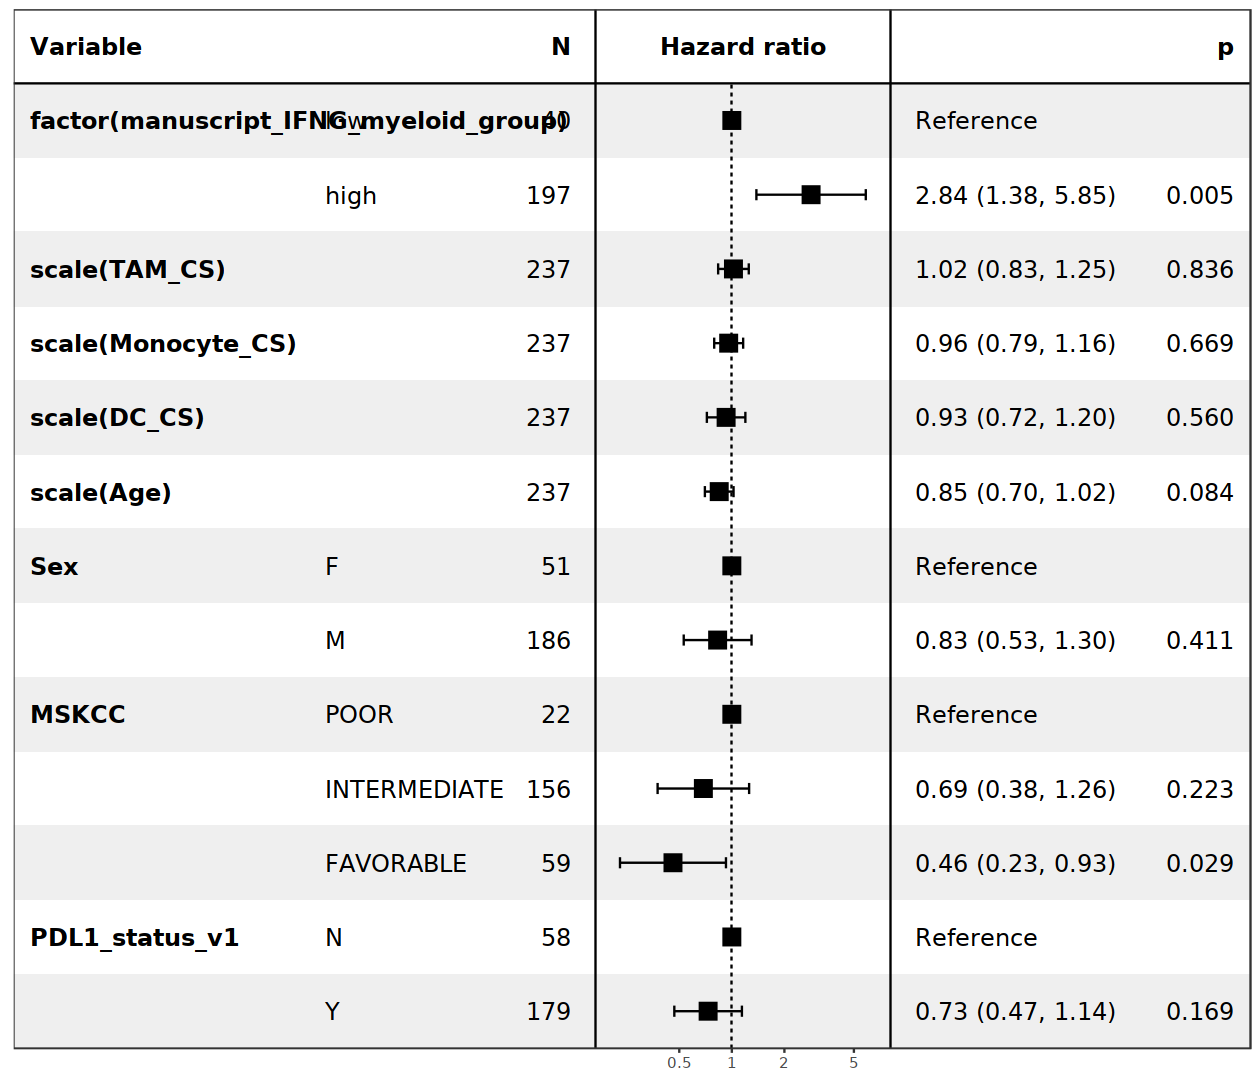

In [47]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
jav101_icb_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_icb_plot

### Sunitinib arm

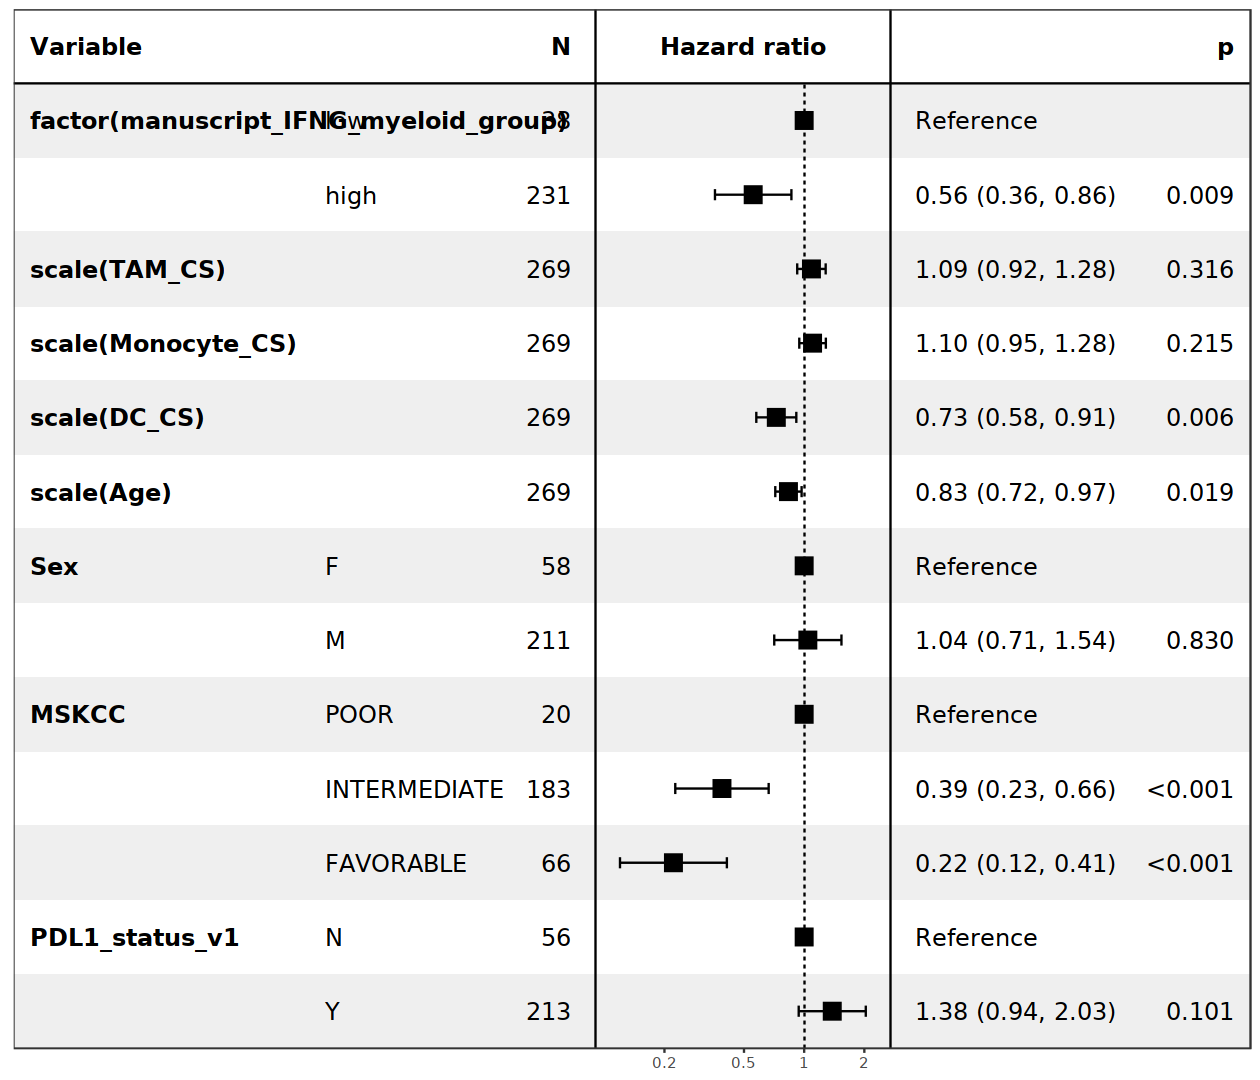

In [48]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib_topcd8)
jav101_tki_plot = forest_model(res.cox, panels,recalculate_width = F)
jav101_tki_plot

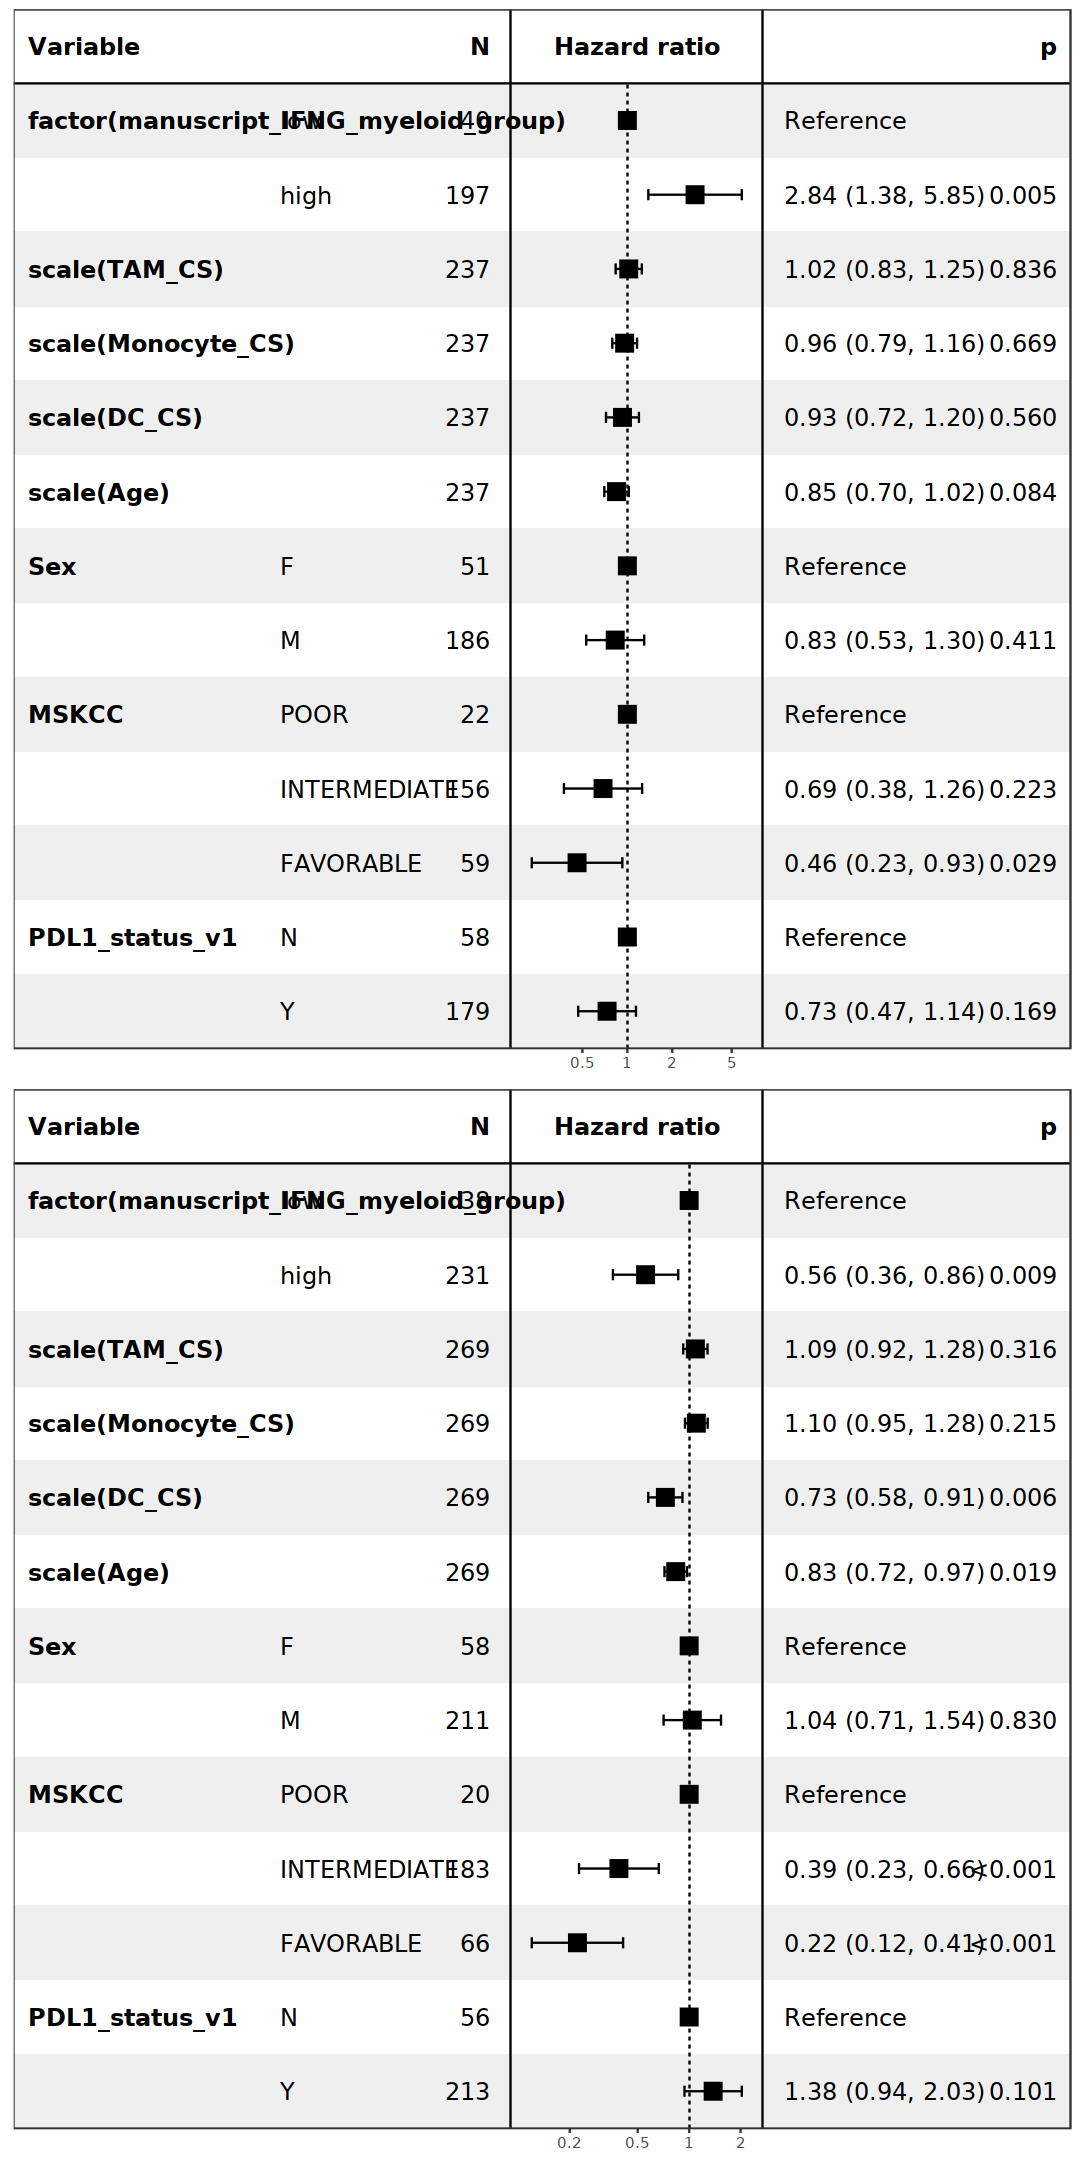

In [49]:
options(repr.plot.width=9, repr.plot.height=18)

ggarrange(jav101_icb_plot, jav101_tki_plot,ncol = 1)

ggsave("../../Supp_Figures/Supp_Figure8_9/Supp_Figure9C_D_Cox_CD8High_JAV101_ICB_TKI_Scaled.pdf",width = 9, height = 18)

### Supp Figure 9E. Scatter plot showing hazard ratios in Cox models for PFS for all myeloid signatures in IMM151 and JAV101 (IFNG signatures) <a name="5"></a>

### Identify all myeloid signatures of interest (mcdermott, braun, krishna, kinget etc)

In [50]:
ISG_sigs = readRDS("../../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [51]:
grep("myeloid",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("tam",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("monocyte",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("dc",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("macrophage",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("mac",names(ISG_sigs),ignore.case=TRUE,value=TRUE)

[1] "manuscript_IFN1_myeloid"        "manuscript_IFNG_myeloid"       
[3] "manuscript_myeloid_combined"    "immotion.myeloid"              
[5] "MCDERMOTT_MYELOID_INFLAMMATION"

[1] "TAM_NISG"                  "TAMsurr_score"            
 [3] "TAMsurr_TcClassII_ratio"   "Krishna_TAM_ISGInt"       
 [5] "Krishna_TAM_HLAhi"         "Krishna_TAM_ISGhi"        
 [7] "Krishna_TAM_HLAint"        "Krishna_TAM_Intersect"    
 [9] "Krishna_TAM_HLAint_Unique" "Krishna_TAM_HLAhi_Unique" 
[11] "Krishna_TAM_ISGInt_Unique" "Krishna_TAM_ISGhi_Unique"

[1] "Monocyte_NISG"

[1] "DC_NISG" "aDC"     "DC"      "iDC"     "pDC"

[1] "Macrophages"

[1] "Macrophages"

In [52]:
myeloid_sigs = c("tLHP_signature","MCDERMOTT_MYELOID_INFLAMMATION","Krishna_TAM_ISGInt","Krishna_TAM_ISGhi","Krishna_TAM_HLAint","Krishna_TAM_HLAhi","TAM_NISG","Monocyte_NISG","DC_NISG","TAMsurr_score","manuscript_IFNG_myeloid")

### Run Cox models for PFS in IMM151 and JAV101 using these signatures. We also calculate a VIF using a regular linear model for CYT, as the vif function is not suitable for use on Cox models

In [53]:
clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

In [54]:
imm151_res = list()
for (i in 1:length(myeloid_sigs)){
    atezo_bev2 = atezo_bev
    atezo_bev2$test = as.numeric(atezo_bev2[,myeloid_sigs[i]])
    res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev2)
    summary_res = summary(res.cox)$coefficients
    
    pretend.lm <- lm(scale(CYT) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev2)
    vif_res_cox = vif(pretend.lm)

    
    myl_summary = summary_res["scale(test)",]
    
    final_result = c(myl_summary,max(vif_res_cox[,"GVIF"]))
    
    imm151_res[[i]] = final_result
    
}

names(imm151_res) = myeloid_sigs
imm151_res_df = data.frame(t(as.data.frame(imm151_res)))
colnames(imm151_res_df) = c("coef",'HR',"se_coef","z","pval","Cox_dummy_lm_maxVIF")
colnames(imm151_res_df) = paste("imm151_",colnames(imm151_res_df),sep = "")
imm151_res_df[order(imm151_res_df$imm151_HR, decreasing = T),]

,imm151_coef,imm151_HR,imm151_se_coef,imm151_z,imm151_pval,imm151_Cox_dummy_lm_maxVIF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Krishna_TAM_ISGInt,0.53704208,1.710939,0.19532542,2.749474,0.0059691076,11.707233
manuscript_IFNG_myeloid,0.46199525,1.587238,0.14022545,3.294660,0.0009854068,6.930480
Krishna_TAM_HLAint,0.42144181,1.524158,0.12416699,3.394153,0.0006884112,6.128419
Krishna_TAM_HLAhi,0.36424363,1.439425,0.12002371,3.034764,0.0024072411,6.795775
Krishna_TAM_ISGhi,0.30298002,1.353887,0.10529532,2.877431,0.0040092769,5.610823
TAMsurr_score,0.26213207,1.299698,0.09512578,2.755636,0.0058578074,5.102090
DC_NISG,0.20656480,1.229447,0.11020380,1.874389,0.0608768220,6.412710
TAM_NISG,0.20639292,1.229236,0.10835419,1.904799,0.0568062381,5.888877
Monocyte_NISG,0.19993057,1.221318,0.10364186,1.929052,0.0537243608,6.426619


In [55]:
avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

In [56]:
jav101_res = list()
for (i in 1:length(myeloid_sigs)){
    avel_axit2 = avel_axit
    avel_axit2$test = as.numeric(avel_axit2[,myeloid_sigs[i]])
    res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit2)
    summary_res = summary(res.cox)$coefficients
    
    pretend.lm <- lm(scale(CYT) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit2)
    vif_res_cox = vif(pretend.lm)

    
    myl_summary = summary_res["scale(test)",]
    
    final_result = c(myl_summary,max(vif_res_cox[,"GVIF"]))
    
    jav101_res[[i]] = final_result
    
}

names(jav101_res) = myeloid_sigs
jav101_res_df = data.frame(t(as.data.frame(jav101_res)))
colnames(jav101_res_df) = c("coef",'HR',"se_coef","z","pval","Cox_dummy_lm_maxVIF")
colnames(jav101_res_df) = paste("jav101_",colnames(jav101_res_df),sep = "")
jav101_res_df[order(jav101_res_df$jav101_HR, decreasing = T),]

,jav101_coef,jav101_HR,jav101_se_coef,jav101_z,jav101_pval,jav101_Cox_dummy_lm_maxVIF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Krishna_TAM_ISGInt,0.55994245,1.750572,0.2525826,2.2168685,0.02663208,11.533021
manuscript_IFNG_myeloid,0.40671045,1.501869,0.1892002,2.1496301,0.03158448,7.464799
Krishna_TAM_HLAint,0.34748587,1.415504,0.1648950,2.1073160,0.03509020,5.512972
Krishna_TAM_HLAhi,0.34055858,1.405733,0.1622831,2.0985457,0.03585697,5.873729
TAMsurr_score,0.26190468,1.299403,0.1289354,2.0312860,0.04222599,4.315479
MCDERMOTT_MYELOID_INFLAMMATION,0.21846073,1.244160,0.1020675,2.1403545,0.03232613,3.859907
TAM_NISG,0.19238186,1.212133,0.1309761,1.4688320,0.14187836,5.994065
DC_NISG,0.14815787,1.159696,0.1370669,1.0809166,0.27973422,6.226459
Monocyte_NISG,0.14748372,1.158914,0.1235944,1.1932876,0.23275675,6.276369


### We'll only consider signatures where the model covariates all had VIF < 10

In [57]:
imm151_res_df = subset(imm151_res_df, imm151_Cox_dummy_lm_maxVIF < 10)
jav101_res_df = subset(jav101_res_df, jav101_Cox_dummy_lm_maxVIF < 10)
setequal(row.names(imm151_res_df), row.names(jav101_res_df))

scatter_df = cbind(imm151_res_df[,c("imm151_HR","imm151_pval")],jav101_res_df[,c("jav101_HR","jav101_pval")])
scatter_df

[1] TRUE

,imm151_HR,imm151_pval,jav101_HR,jav101_pval
,<dbl>,<dbl>,<dbl>,<dbl>
tLHP_signature,1.187407,0.0776969940,1.069487,0.55935357
MCDERMOTT_MYELOID_INFLAMMATION,1.088997,0.2560913722,1.244160,0.03232613
Krishna_TAM_ISGhi,1.353887,0.0040092769,1.124781,0.35482287
Krishna_TAM_HLAint,1.524158,0.0006884112,1.415504,0.03509020
Krishna_TAM_HLAhi,1.439425,0.0024072411,1.405733,0.03585697
TAM_NISG,1.229236,0.0568062381,1.212133,0.14187836
Monocyte_NISG,1.221318,0.0537243608,1.158914,0.23275675
DC_NISG,1.229447,0.0608768220,1.159696,0.27973422
TAMsurr_score,1.299698,0.0058578074,1.299403,0.04222599


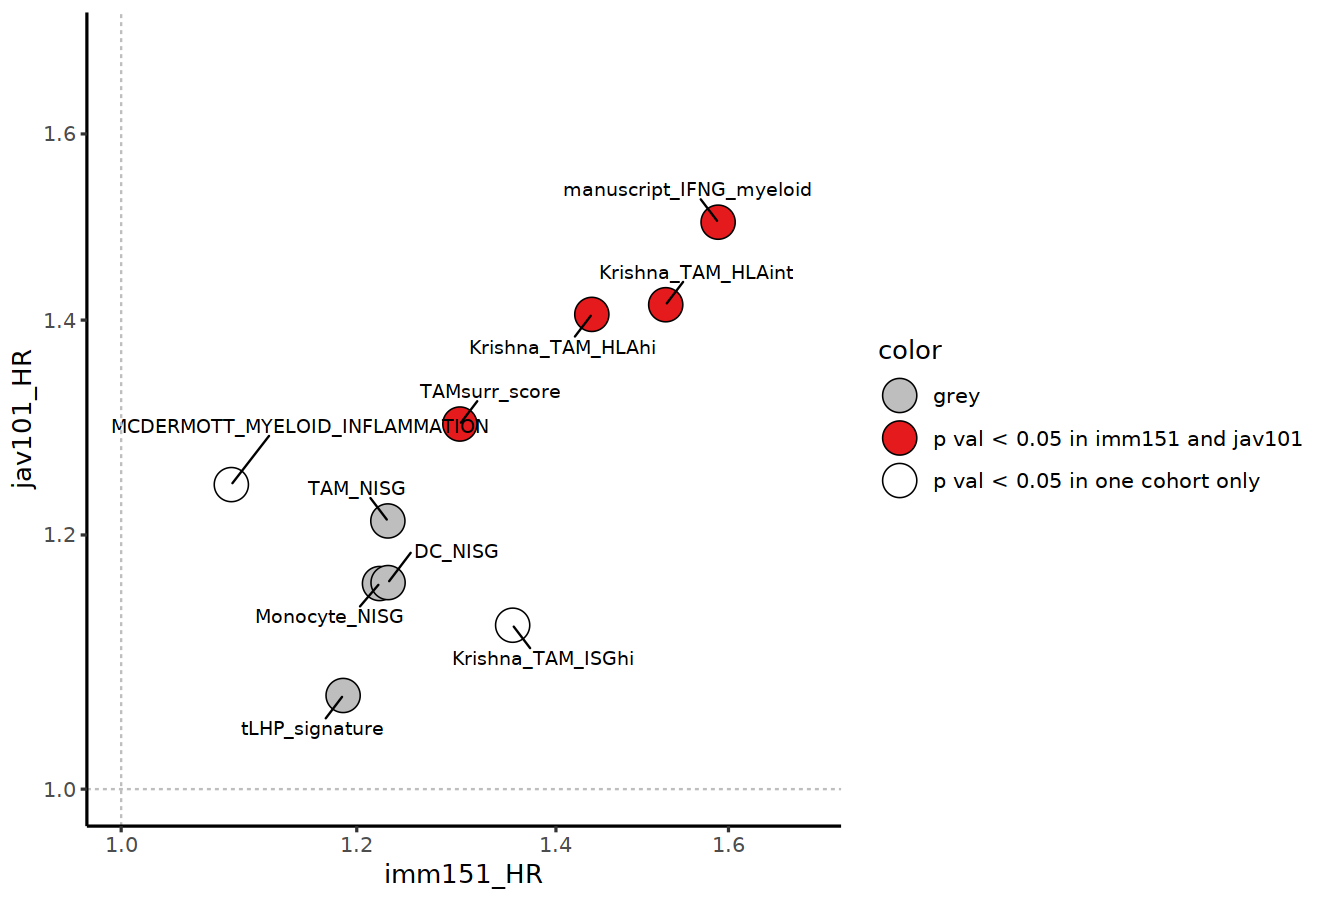

In [58]:
scatter_df = mutate(scatter_df, color = ifelse(imm151_pval < 0.05 & jav101_pval < 0.05, "p val < 0.05 in imm151 and jav101",ifelse(imm151_pval < 0.05 | jav101_pval < 0.05, "p val < 0.05 in one cohort only","grey")))
scatter_df$label = row.names(scatter_df)

library(ggrepel)
options(repr.plot.width=11, repr.plot.height=7.5)
ggplot(scatter_df, aes(x=imm151_HR, y=jav101_HR, fill = color, label = label)) +
  geom_point(size=9, shape = 21) + theme_classic(base_size = 15) + scale_fill_manual(values = c("grey","#e41a1c","white")) + geom_text_repel(box.padding = 1) +
geom_vline(xintercept = 1, color = "grey",linetype = "dashed") + 
geom_hline(yintercept = 1, color = "grey",linetype = "dashed") +
coord_trans(x = c("log"), y = c("log"),xlim = c(1,1.7),ylim = c(1,1.7))

ggsave("../../Supp_Figures/Supp_Figure8_9/Figure9E_scatter_myeloid_HRs_Scaled.pdf", width = 11, height = 7.5)